In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
plt.style.use('stash/pp2latex.mplstyle')
plt.rcParams["font.family"] = "Times New Roman"

# Data Import

In [3]:
co2y = np.loadtxt('../measurements/TCS_resp/CO2Y_point95W_step_minute_trend_october_18_2018.dat')     # CO2Y change by .95 W (Sensed by HWSY)
rhy = np.loadtxt('../measurements/TCS_resp/ITMY_trend_10min_int_longer.dat')                          # RHY change by ? W (Sensed by HWSY)
carr_self = np.loadtxt('../measurements/TCS_resp/1W_self_heating_defocus_doublepass.txt', skiprows=1) # Self heating model from COMSOL

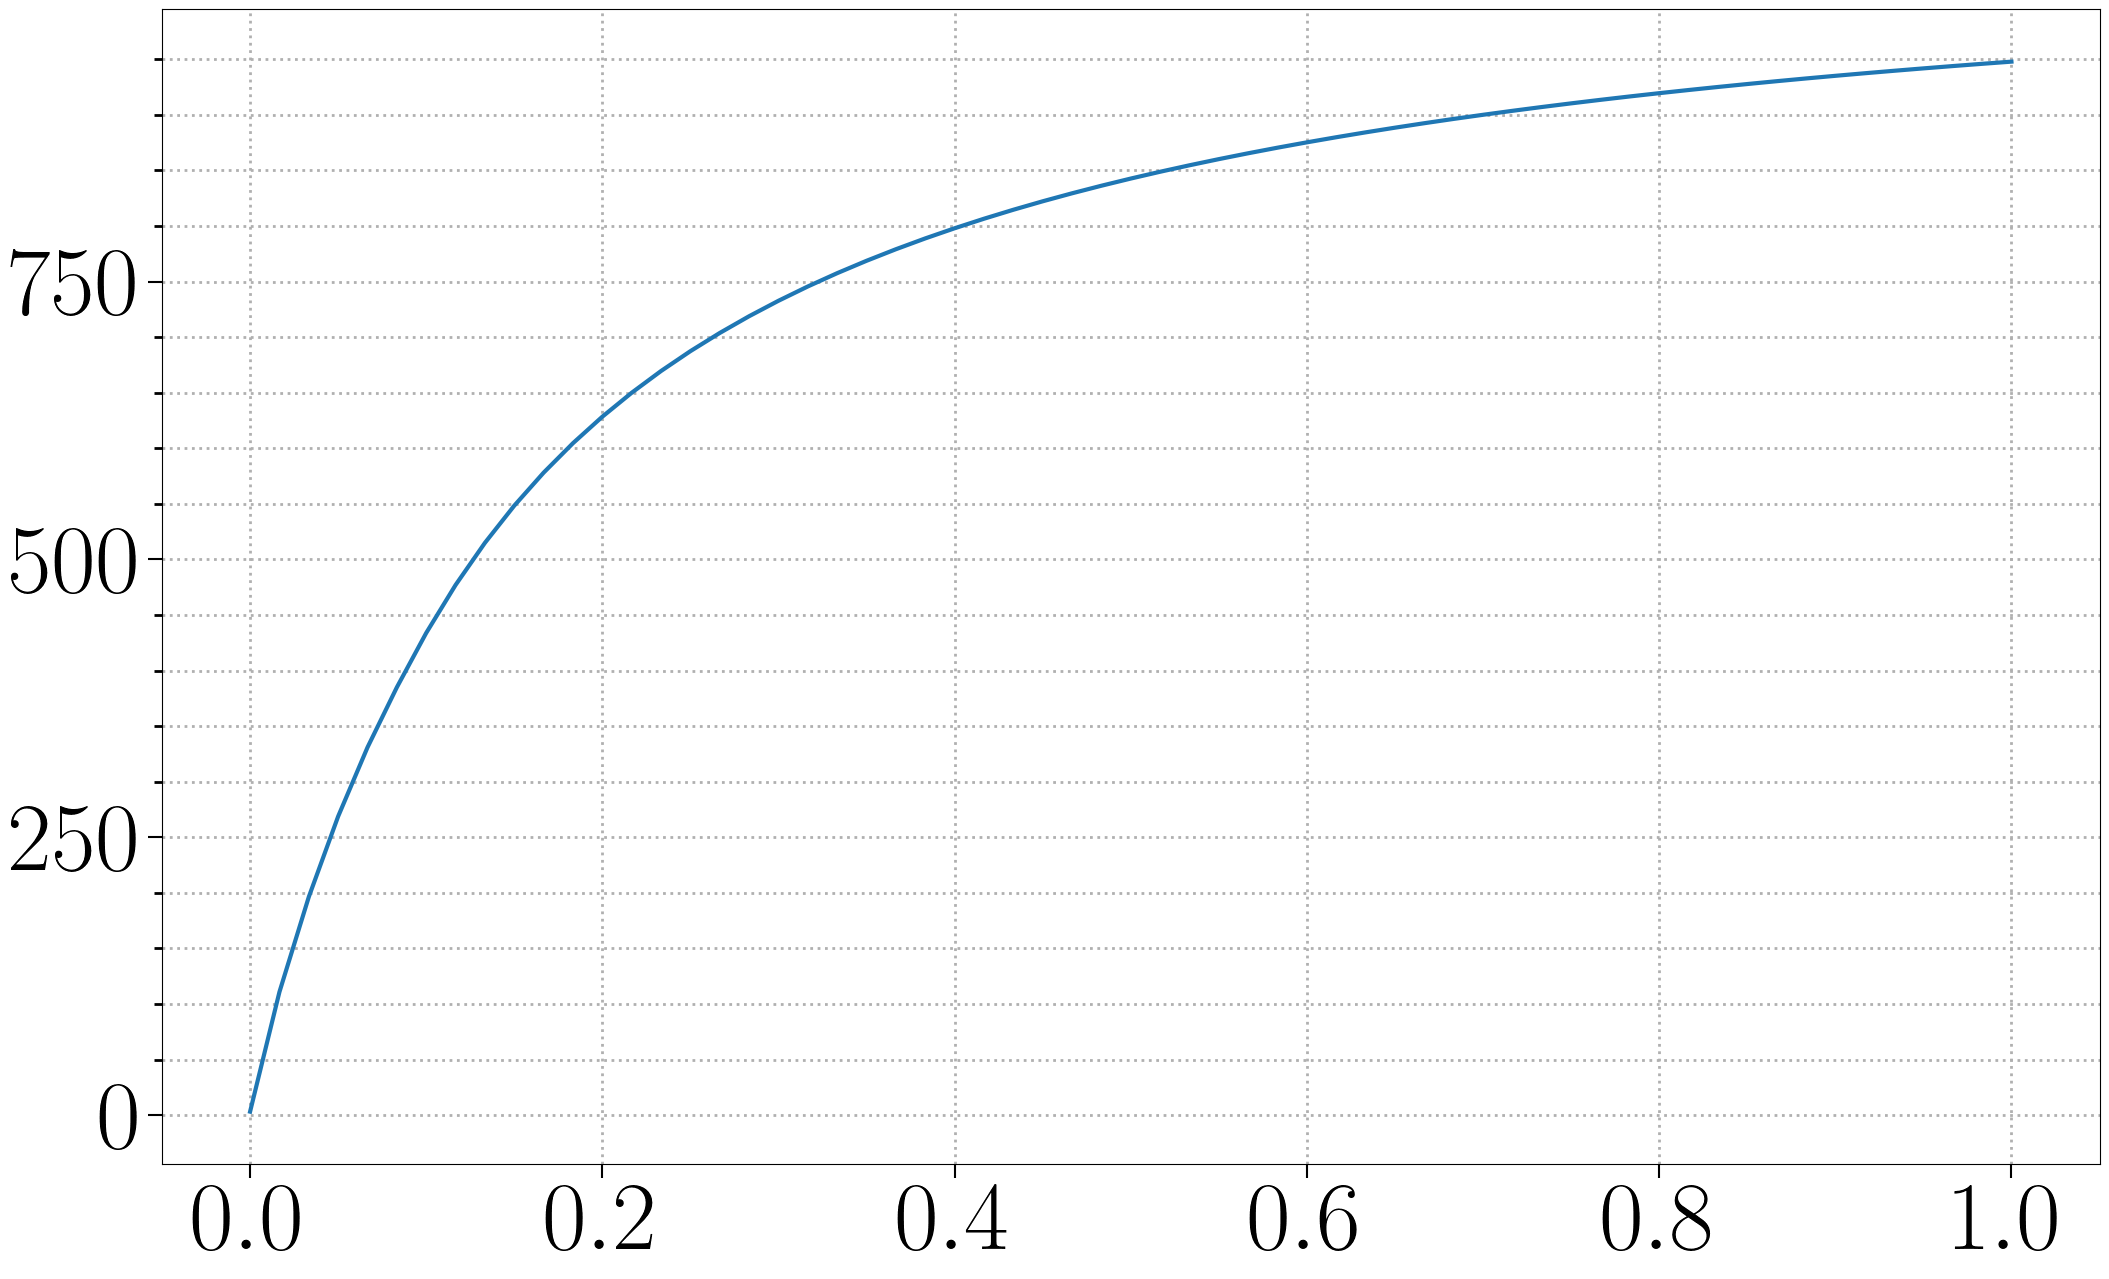

In [4]:
plt.plot(carr_self[:,0], carr_self[:,1])

# Data Pre-filter

Text(0, 0.5, 'Defocus [1/m]')

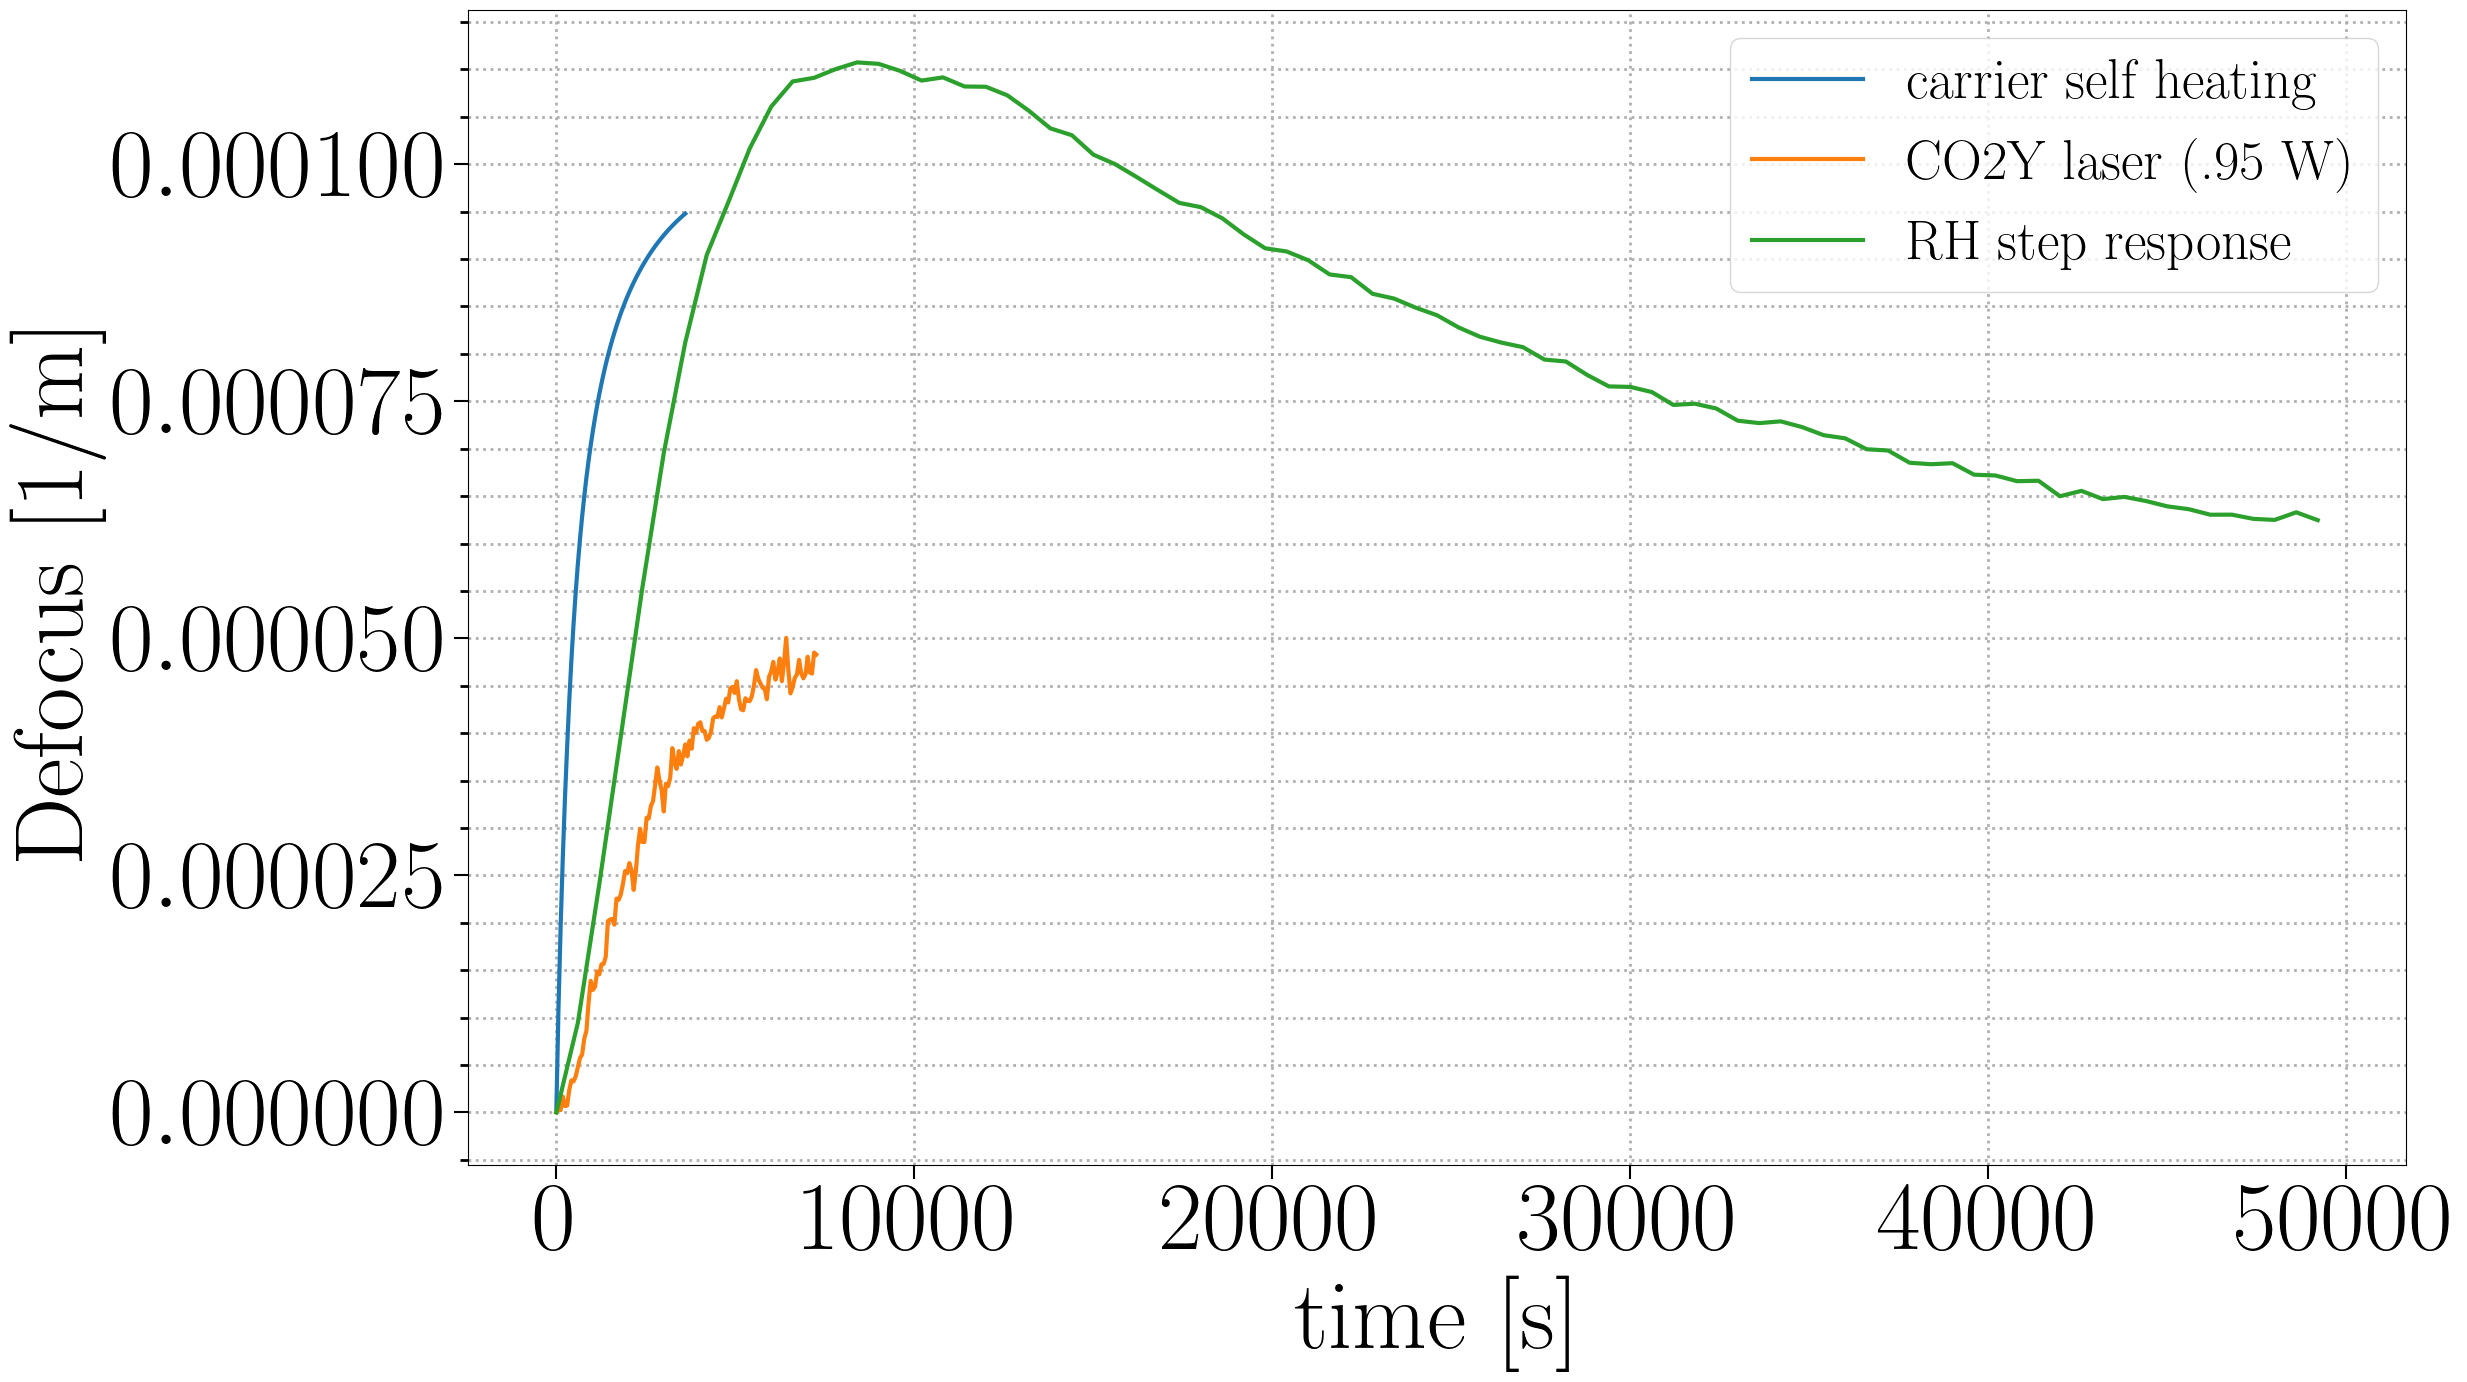

In [5]:
## COMSOL self heating
plt.plot(carr_self[:,0]*60*60, carr_self[:,1]*1e-7, label='carrier self heating')
## OCTOBER 18th CO2Y step response data
t = np.arange(0,len(co2y[:,0]),1)*60
co2y_ = co2y[:,1] + abs(min(co2y[:,1]))
plt.plot(t,co2y_, label='CO2Y laser (.95 W)')

## ITMY RH response data
trhy = np.arange(0,len(rhy[:,1][2:]))*600
plt.plot(trhy, rhy[:,1][2:]-min(rhy[:,1][2:]), label = 'RH step response')

plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Defocus [1/m]')

In [6]:
b, a = signal.butter(4, 0.15)
b2, a2 = signal.butter(3, 0.0512)

In [7]:
b2, a2 = signal.butter(3, 0.0512)
co2y_smooth = signal.filtfilt(b2,a2,co2y[:,1])

In [8]:
y2 = signal.filtfilt(b,a,co2y[:,1])
rhy_smooth = signal.filtfilt(b,a,rhy[:,1][2:])

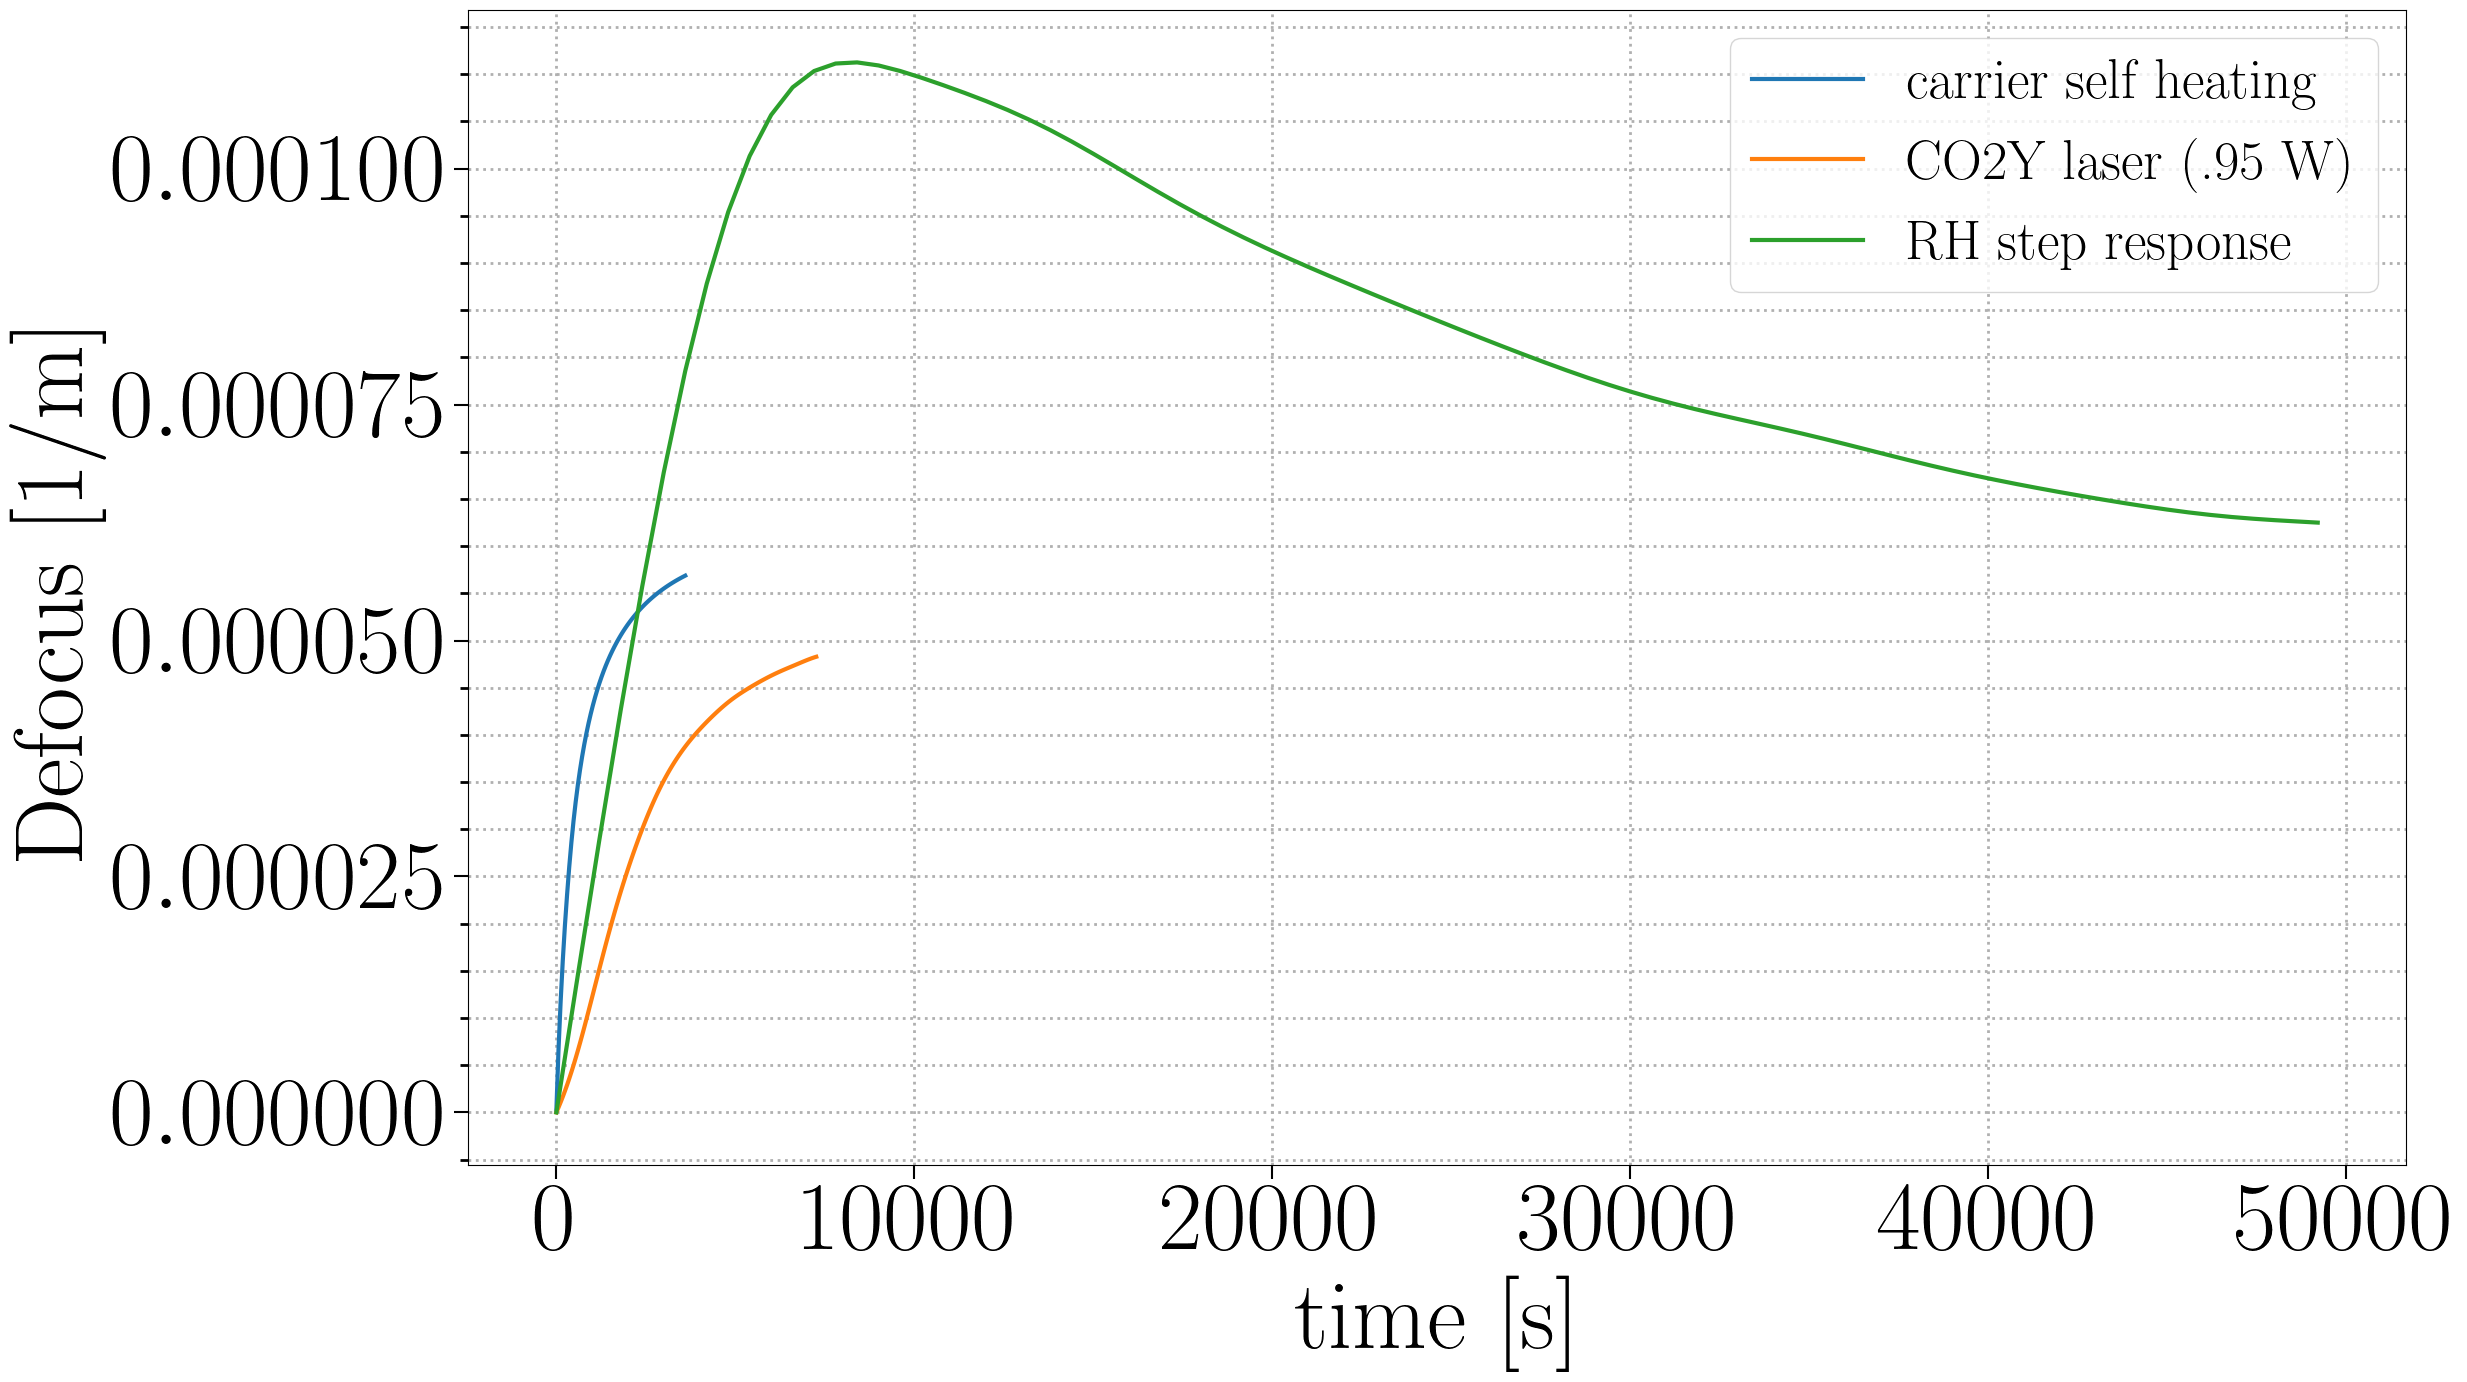

In [9]:
plt.plot(carr_self[:,0]*60*60, carr_self[:,1]*.6e-7, label='carrier self heating')
#plt.plot(t_rhy1,y_self_test_longer*.62e-4,label='fit',linewidth=4)

plt.plot(t,co2y_smooth + abs(min(co2y_smooth)), label='CO2Y laser (.95 W)')

plt.plot(np.arange(0,len(rhy[:,1][2:]))*600,rhy_smooth-min(rhy_smooth), label='RH step response')
#plt.plot(rhy[:,0], rhy[:,1])

plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Defocus [1/m]')
plt.savefig('../figs/TCS/TCS_resp.pdf', dpi=300, bbox_inches='tight')

## Generate TCS filters
* Run through IRHF algorithm
    * Establish power step
    * Build zpk model
        * Divide by set power to set correct gain
        * Apply a Laplace transform to bring response into s-space
        * Multiply step response by zpk filter to match true response
    * Invert filter and apply stability filters
    * Compare to natural response and check for increased efficiency

In [10]:
P_CO2Y = .95     #[W] central heating
P_RH = 3.13      #[W] annular heating 
self_heating = 1 #[W] absorbed power

In [11]:
### RH (plant) filter

83


<Figure size 2500x1500 with 0 Axes>

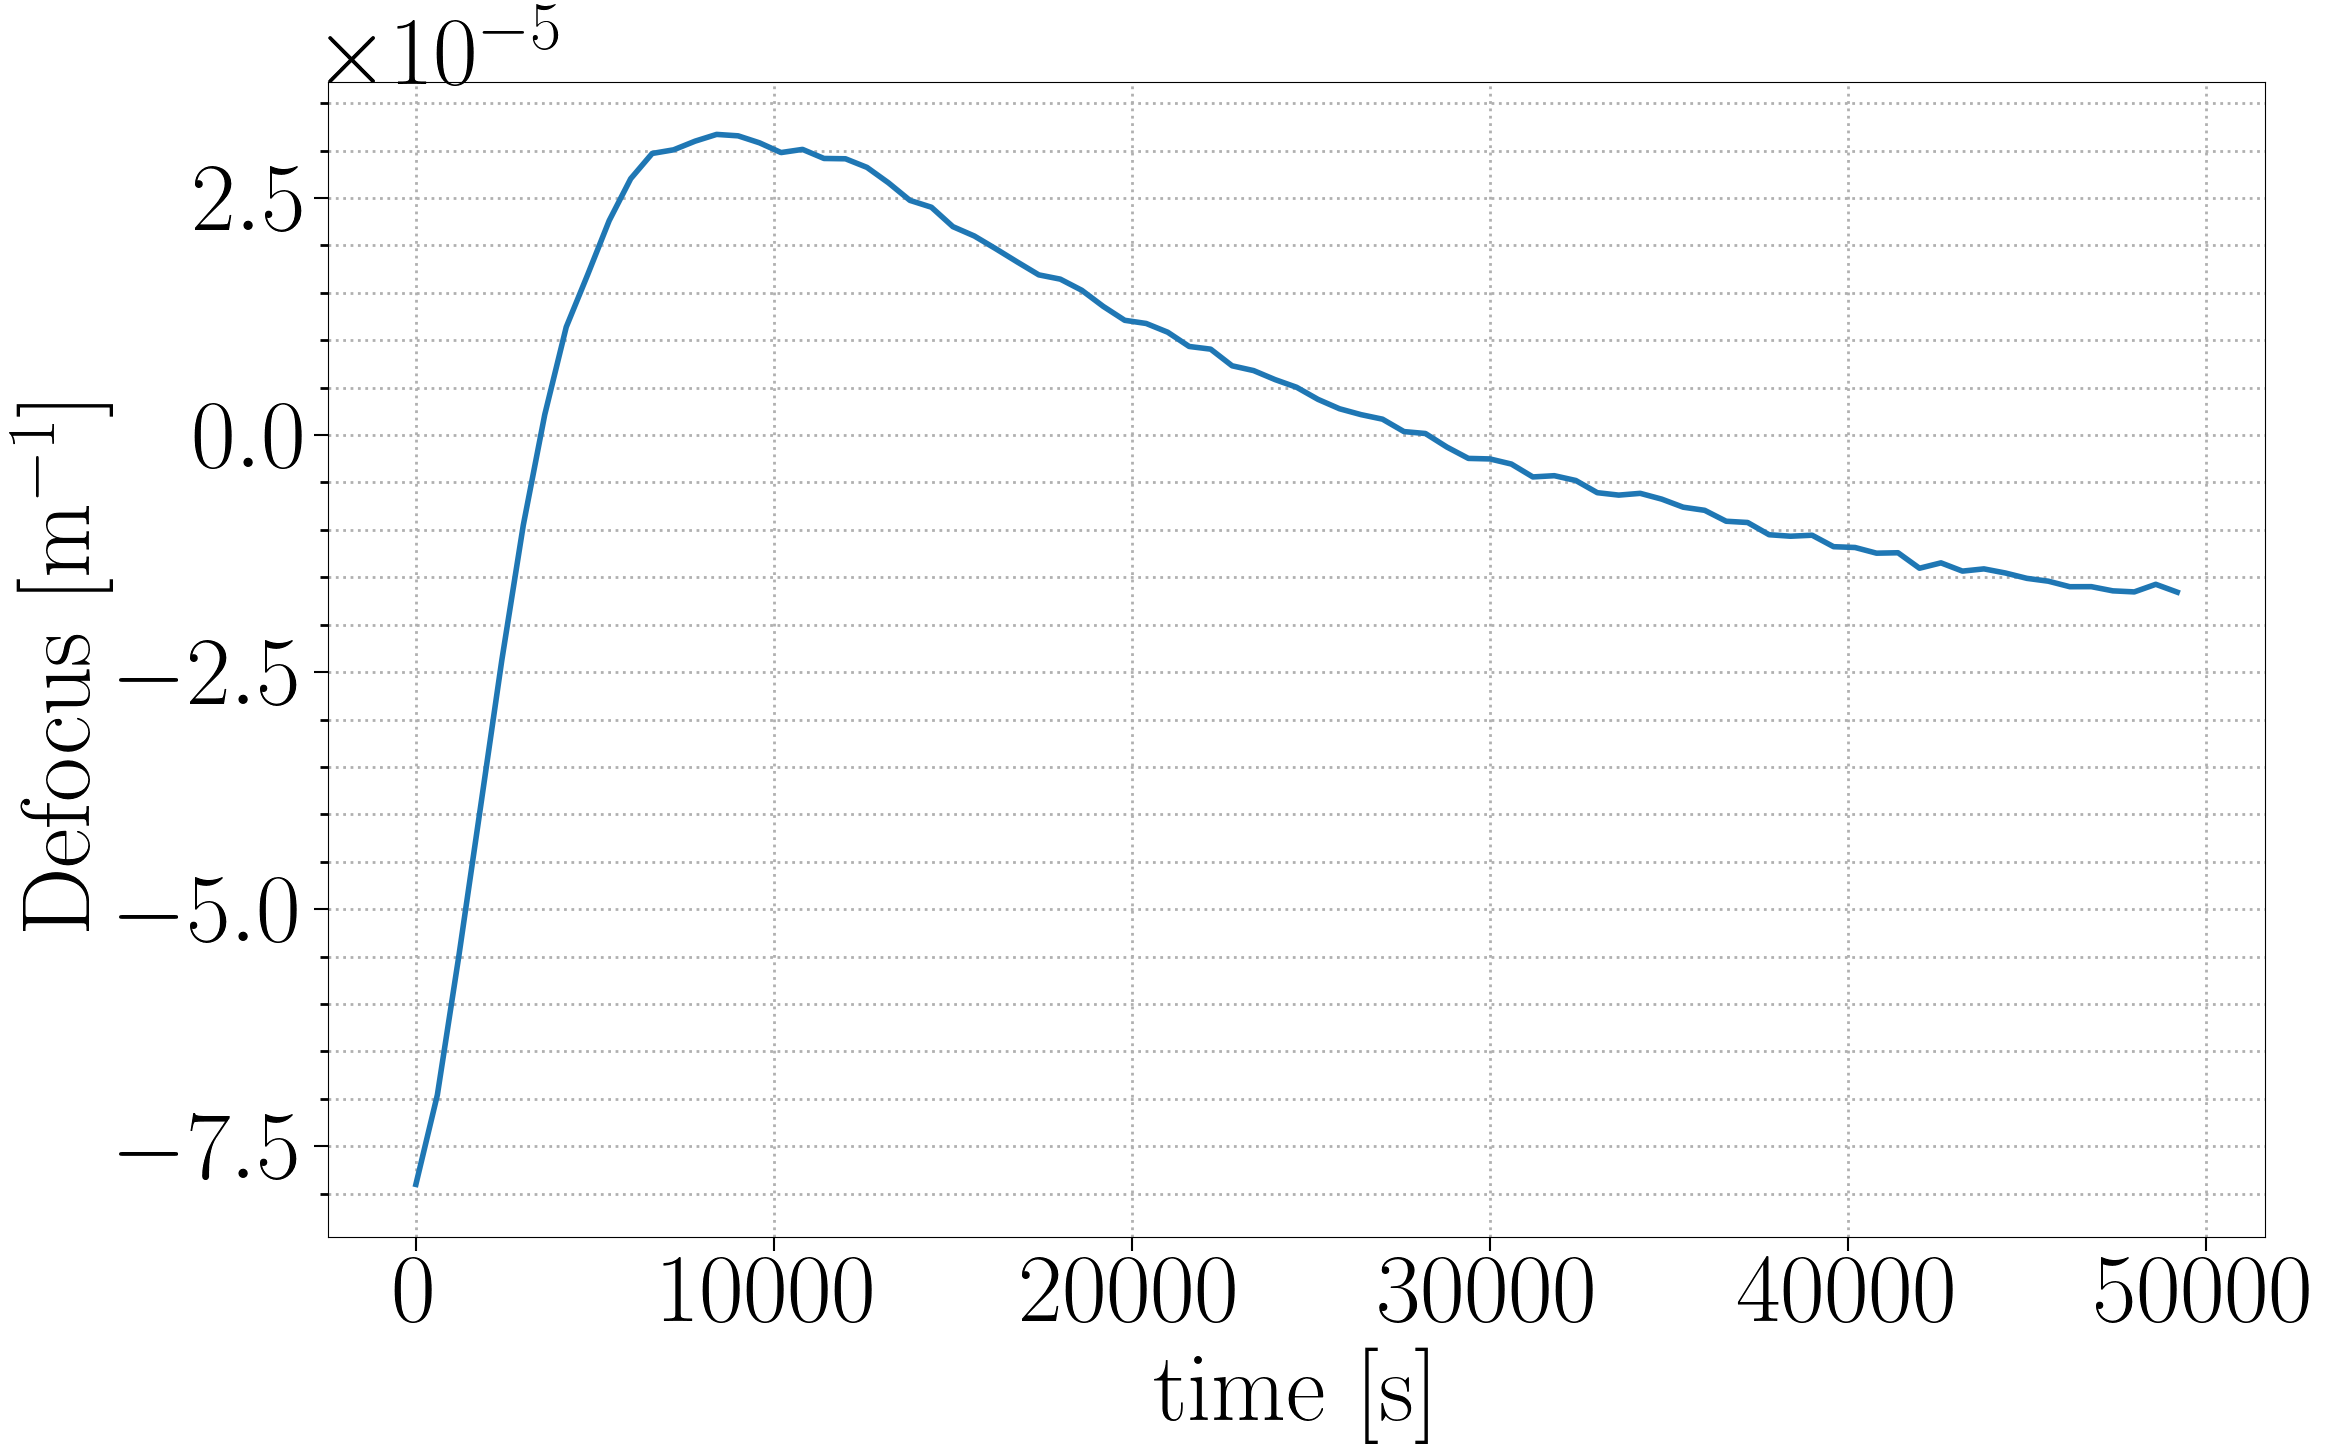

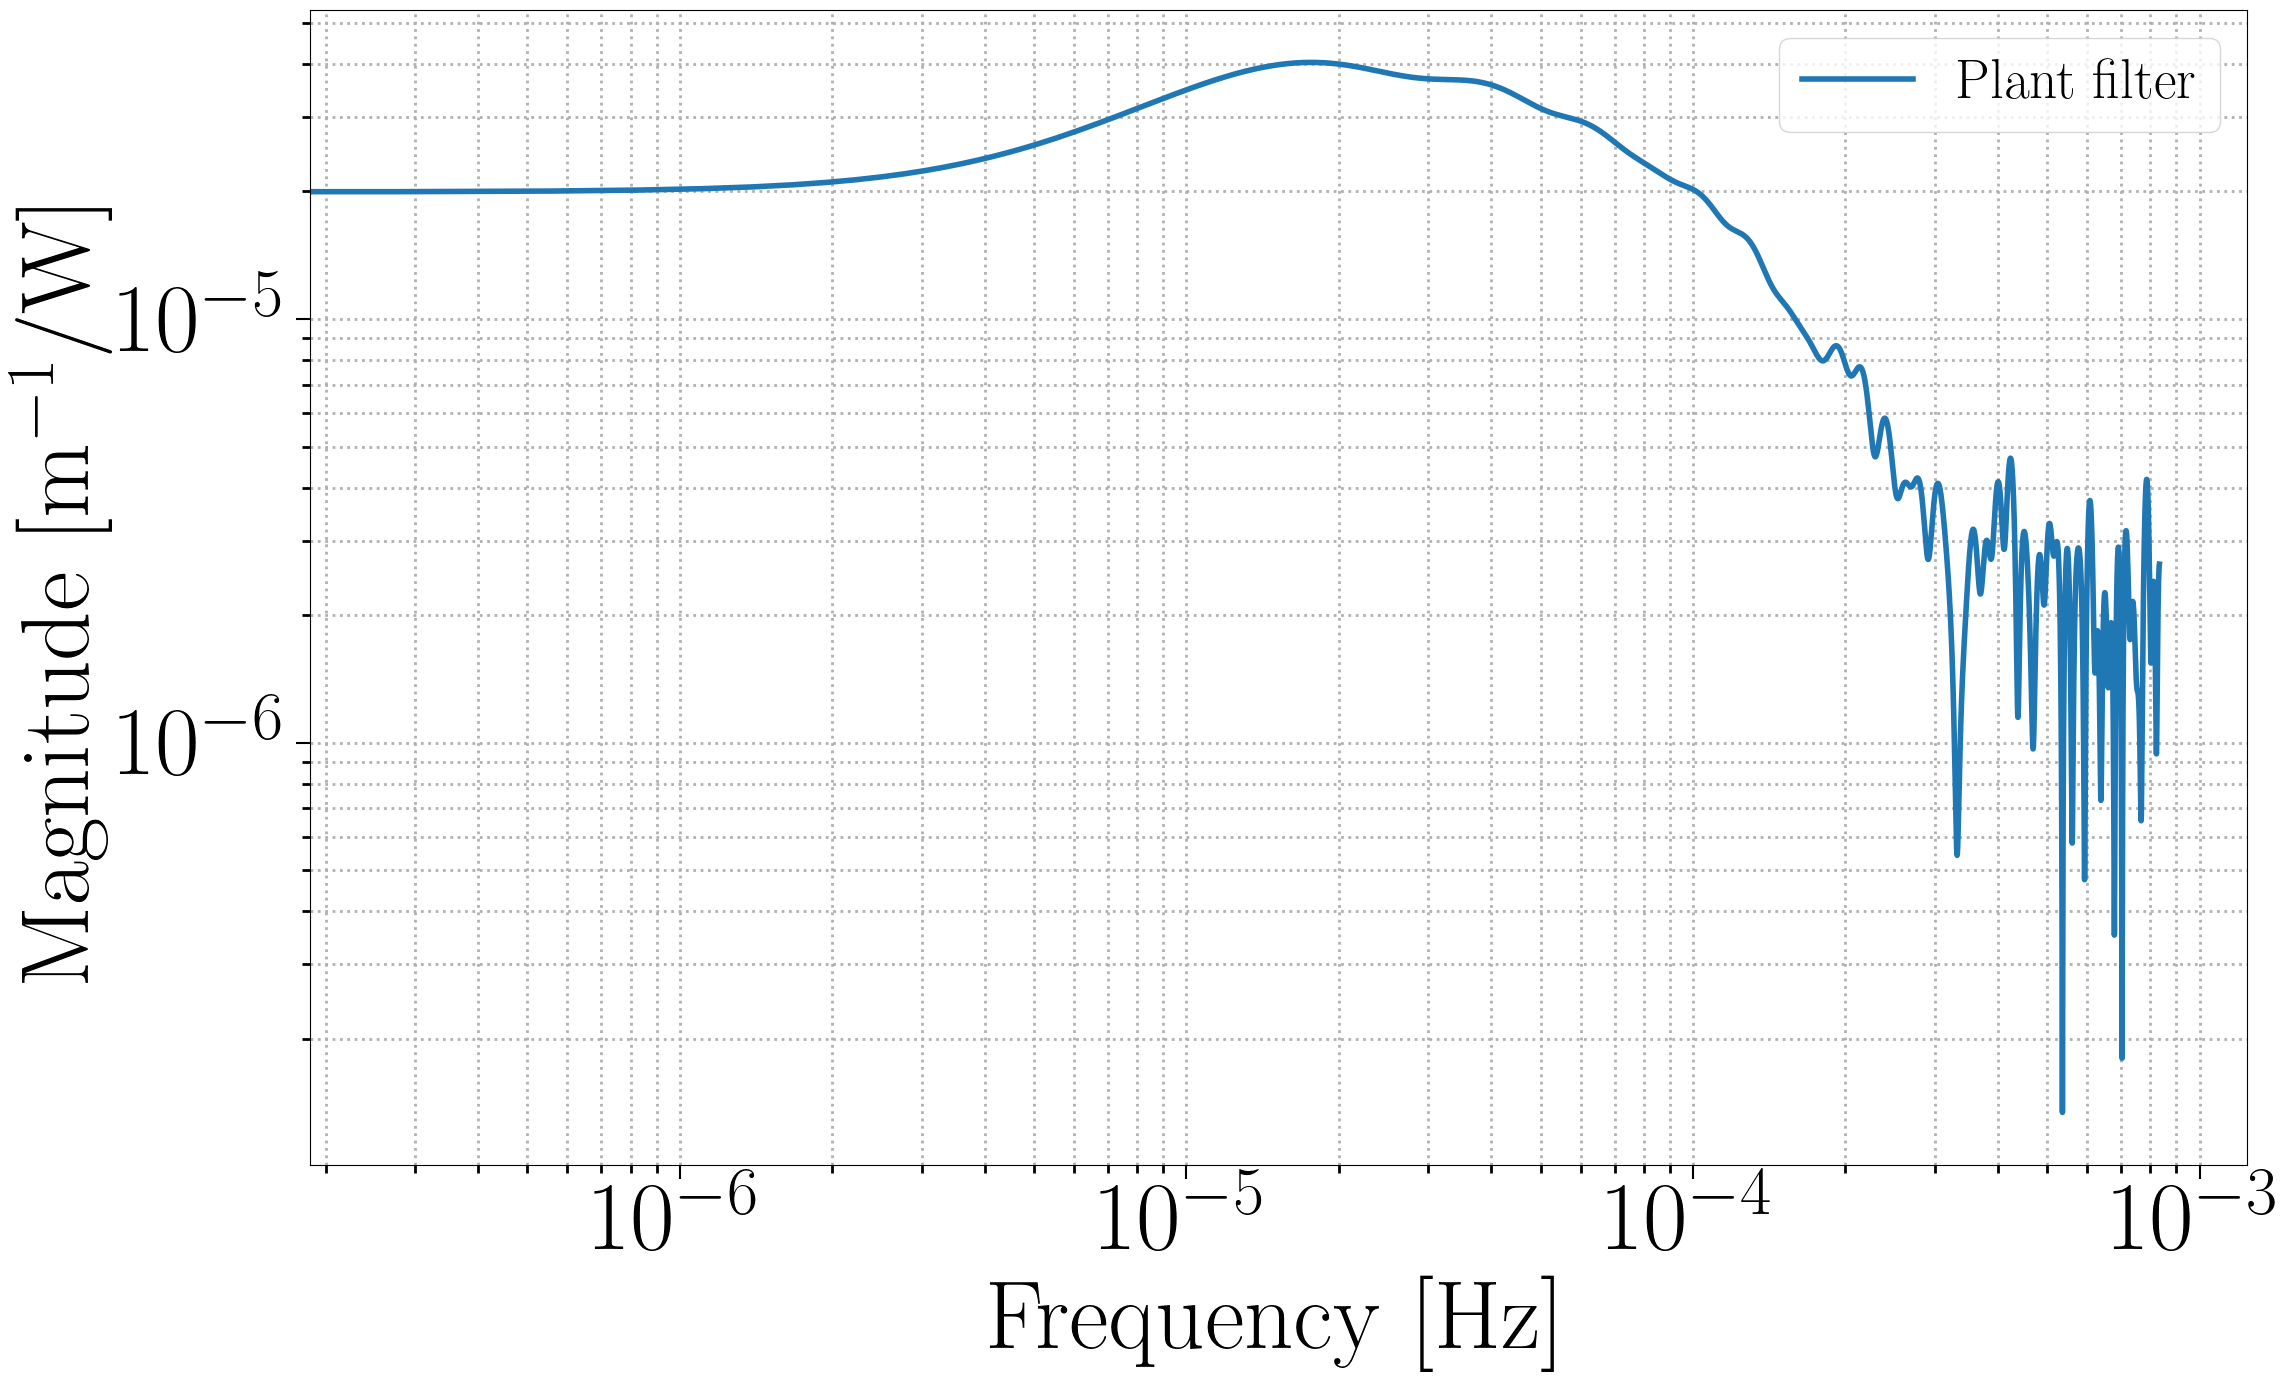

4.993706070287539e-06


In [12]:
normalize = 3.13
print(len(trhy))
rhy_datain = rhy[:,1][2:]
b, a = signal.butter(2, .2)
#data_new = signal.filtfilt(b,a,data_in)
plt.figure()
ir = (rhy_datain[1:] - rhy_datain[:-1])/normalize
fig1 = plt.figure()
plt.plot(trhy, rhy_datain, label='Step response',linewidth=4)
#plt.plot(t[:(len(t)-1)], ir, label= 'Impulse response')
plt.xlabel('time [s]')
plt.ylabel('Defocus [m$^{-1}$]')
#plt.legend(fontsize='medium')
plt.show()

Fs = 1/(trhy[2]-trhy[1])
#print(Fs)

[F,H]=signal.freqz(ir,1, worN=3000,whole=False) 
fig2 = plt.figure()
plt.loglog(F*Fs/(2*np.pi), abs(H), label='Plant filter',linewidth=4)
plt.ylabel('Magnitude [m$^{-1}$/W]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.show()

print(max(ir))


/tmp/ipykernel_3188/2814219194.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,(F[-1]/(2*np.pi)*Fs)])


9.729529652779821e-12


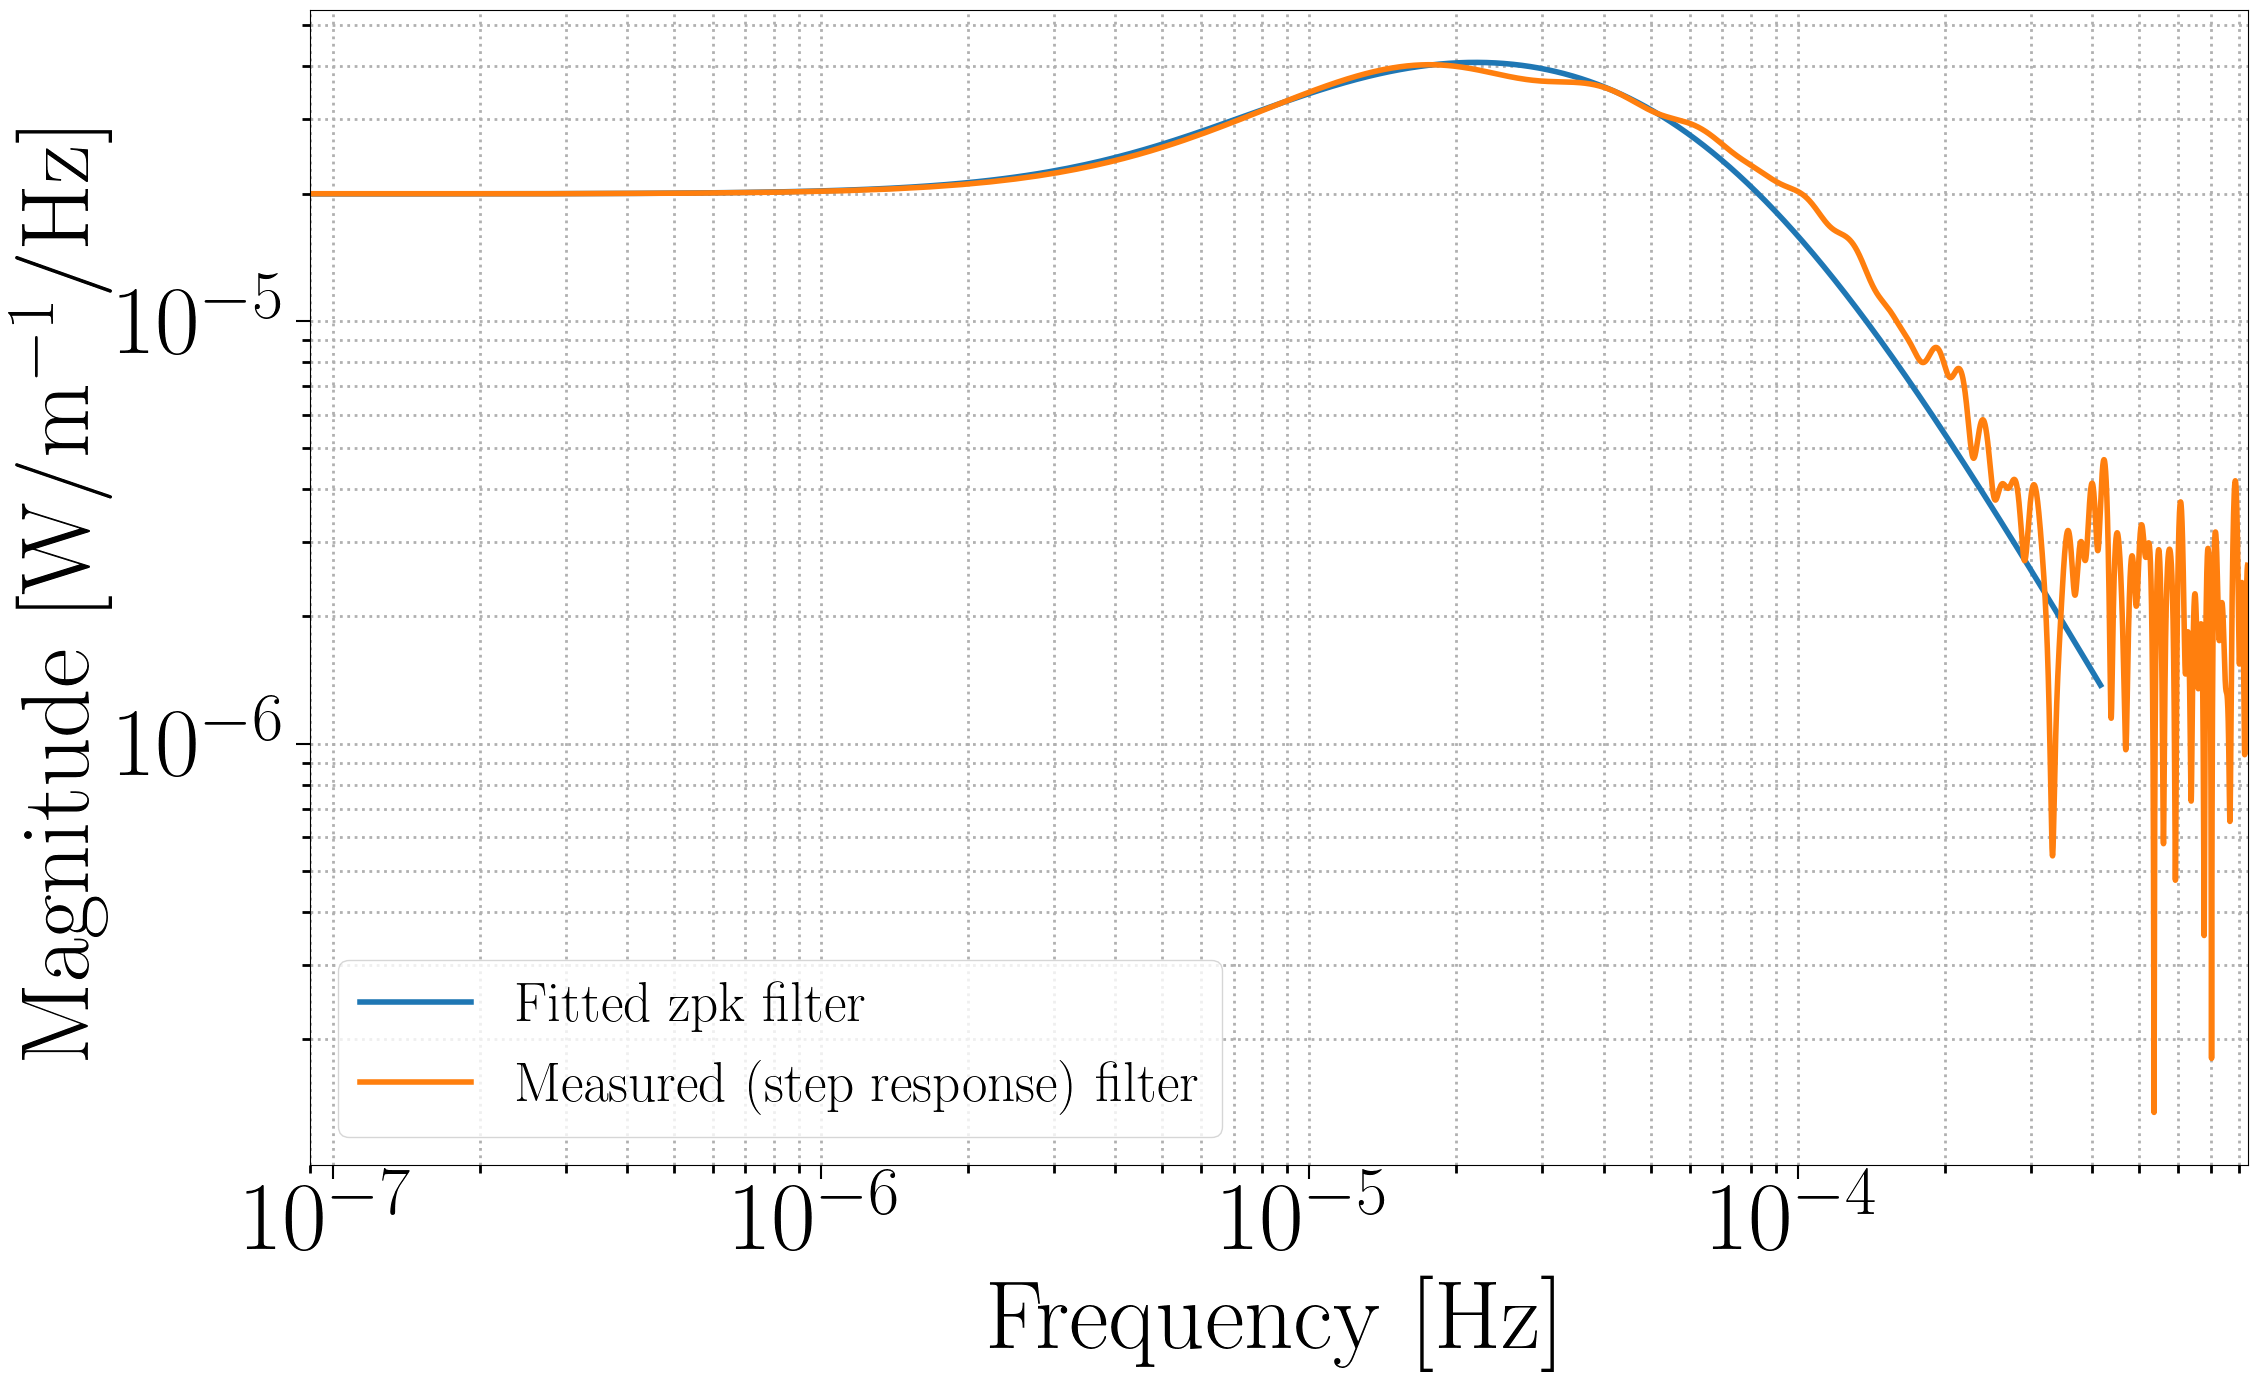

In [13]:
zeros = 5.0e-6
fit_zeros = -2.0*np.pi*5.0e-6
poles = np.array([1.3e-5, 5.0e-5 ,9.5e-5])
fit_poles = -2.0*np.pi*poles

k = 1 #This gain is not initally correct

s1 = signal.ZerosPolesGain(fit_zeros, fit_poles, k)
F_2, H_2 = signal.freqresp(s1, F*(Fs/2.0))

#[F_2,H_2] = signal.freqs(b_2, a_2)
k_new = abs(H[0])/abs(H_2[0])

plt.loglog(F_2/(2*np.pi), abs(H_2)*k_new, label='Fitted zpk filter',linewidth=4)
plt.loglog(F/(2*np.pi)*Fs, abs(H), label='Measured (step response) filter',linewidth=4)
plt.ylabel('Magnitude [W/m$^{-1}/\mathrm{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.legend()
#plt.title('RH plant filter (H(s))')
plt.xlim([0,(F[-1]/(2*np.pi)*Fs)])
print(k_new) #Spit out the new gain
##plt.grid(b=True,which='minor')
##plt.grid(b=True,which='major')
##plt.minorticks_on()

model_zpk = signal.ZerosPolesGain(fit_zeros, fit_poles,k_new)

In [323]:
[ _ ,y_RH_test, _] = signal.lsim(model_zpk, unit_step_testing1, trhy1)

### Self Heating Filter

In [14]:
t_com = carr_self[:,0]*3600
defocus = carr_self[:,1]/max(carr_self[:,1])
ir_com  = (defocus[1:] - defocus[:-1])
t_ir = t_com[:((len(t_com)-1))]

In [15]:
[F_ir,H_ir]=signal.freqz(ir_com, 1, worN=3000,whole=False) 
Fs_com =1/(t_com[1]-t_com[0])

Text(0.5, 1.0, 'Self Heating filter (G$_{2}$(s))')

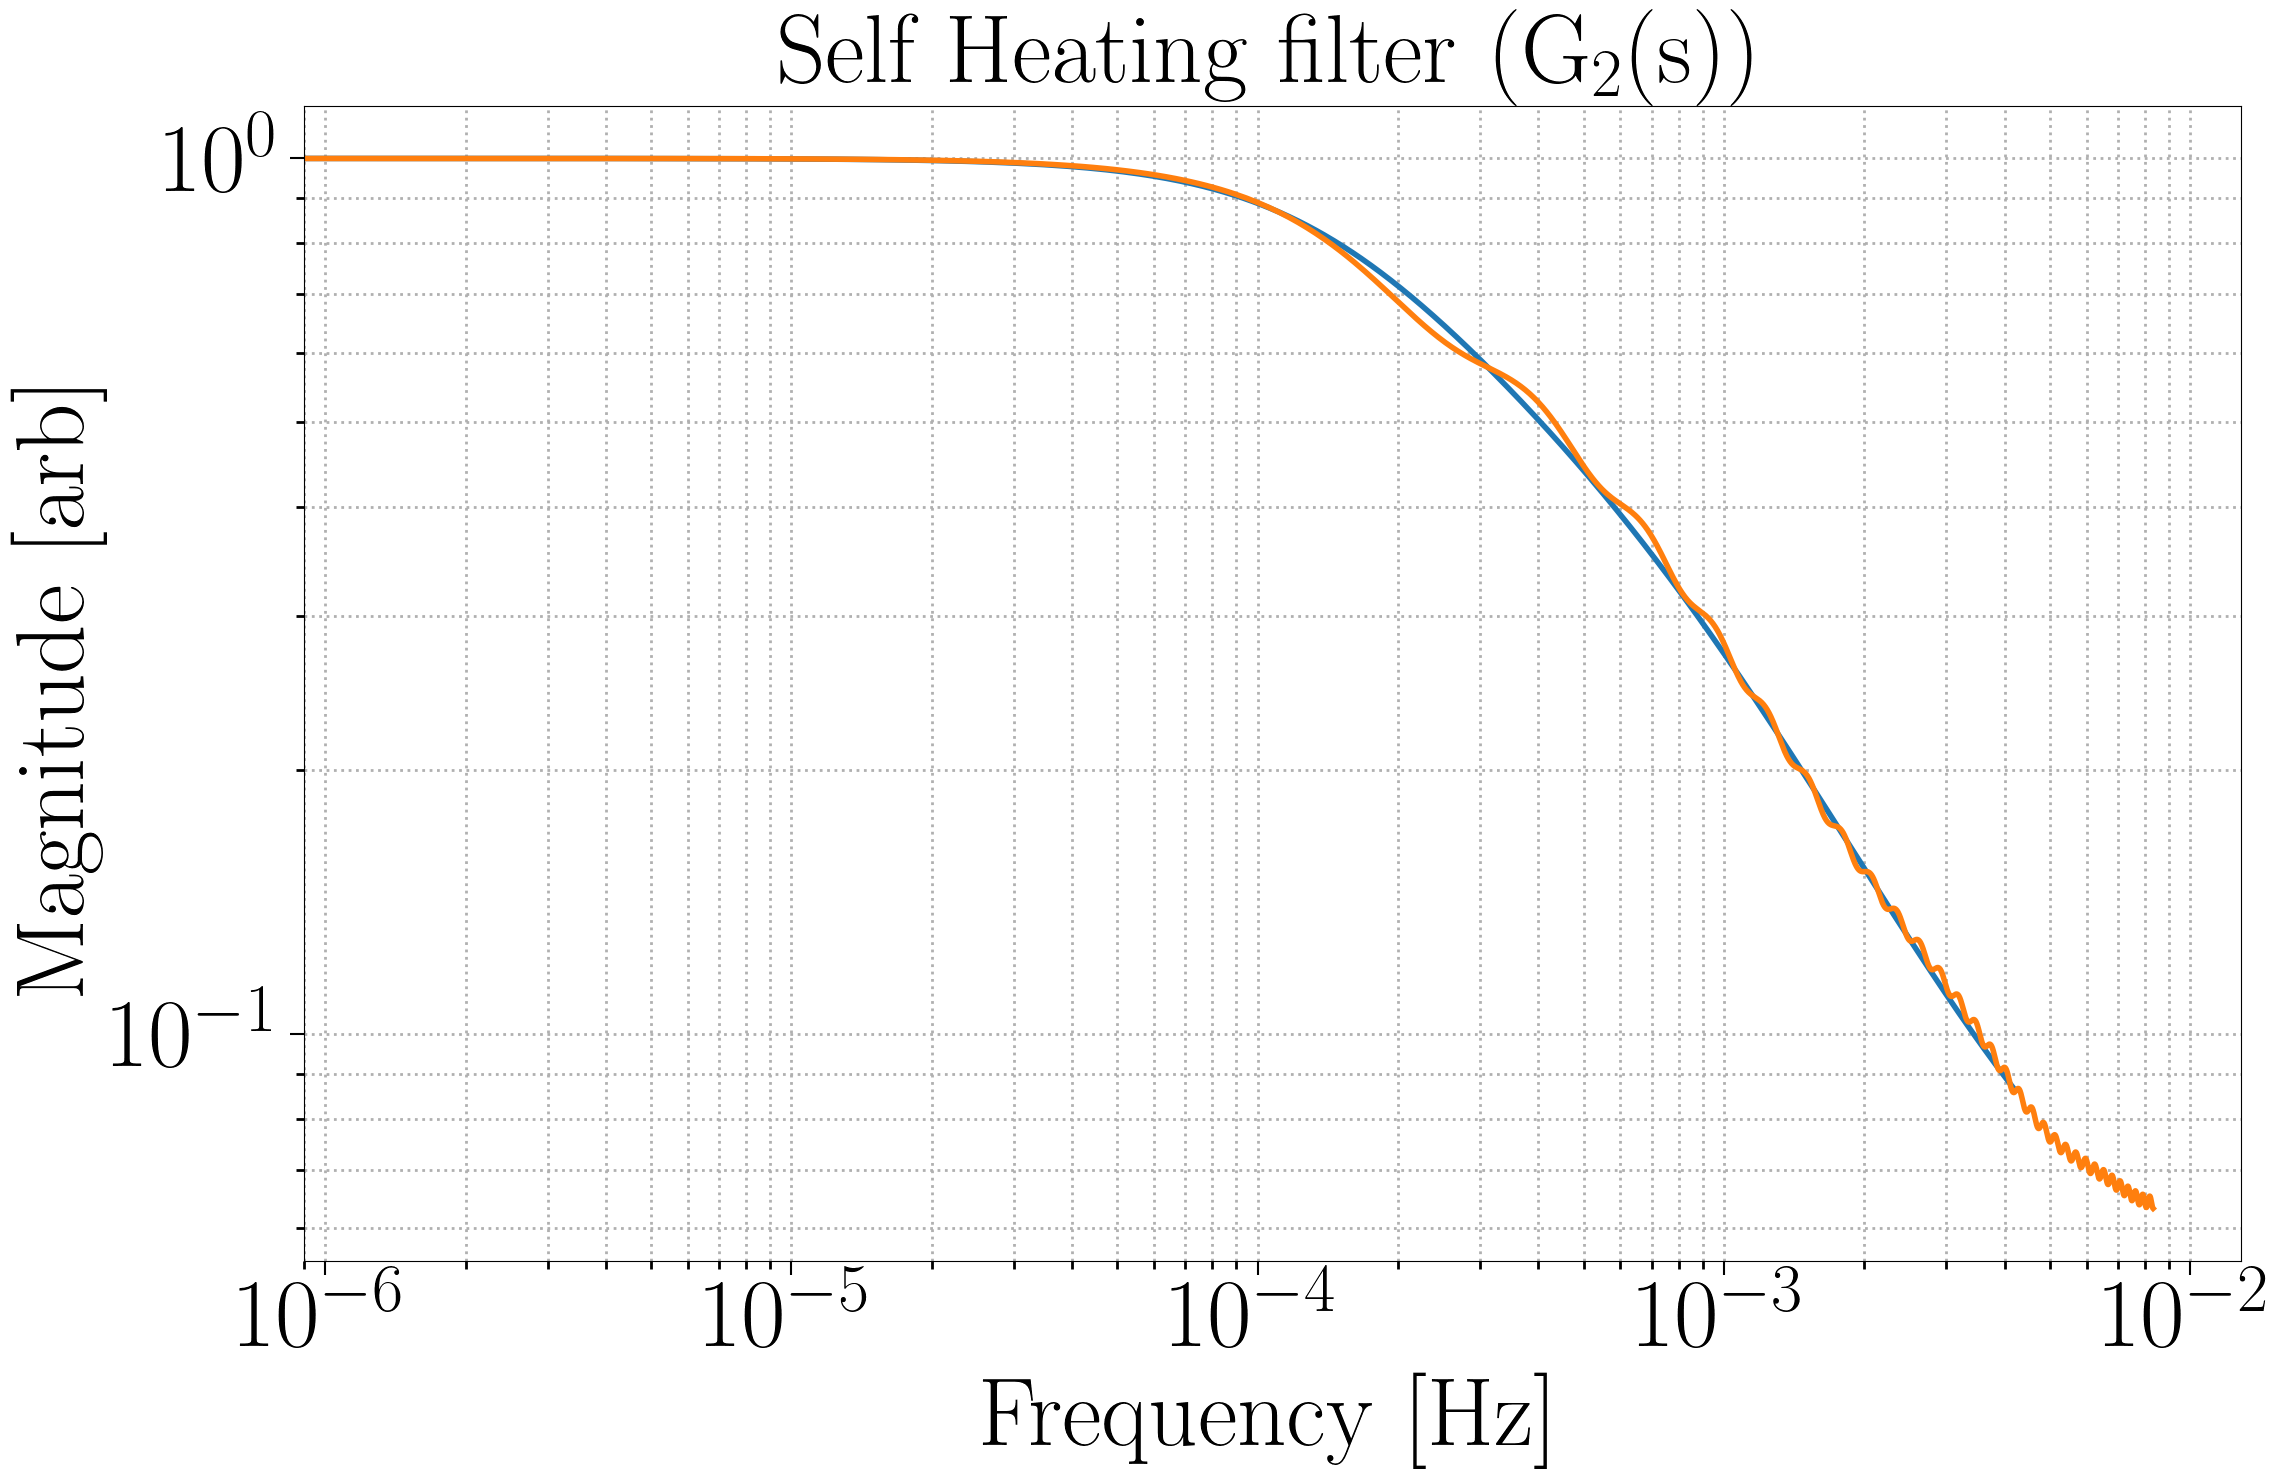

In [17]:
zeros_com = np.array([.27e-3,.7e-3,.28e-3,6.5e-3])
fit_zeros_com = -2.0*np.pi*zeros_com
poles_com = np.array([.18e-3,.225e-3,.485e-3,.83e-3])
fit_poles_com = -2.0*np.pi*poles_com

k_com =.985 #This gain is not initally correct

zpk_com = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_com)
F_com, H_com = signal.freqresp(zpk_com, F_ir*(Fs_com/2.0))
k_new_com = abs(H_ir[0])/abs(H_ir[0]*H_com[0])

fig6 = plt.figure()
plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='Fitted zpk Filter',linewidth=4)
plt.loglog(F_ir*Fs_com/(2*np.pi), abs(H_ir)/abs(H_ir[0]), label='Plant filter',linewidth=4)
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')
plt.title('Self Heating filter (G$_{2}$(s))')

In [332]:
G_3 = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_new_com)
trhy1 = np.arange(0, trhy[-1],60)
unit_step_testing1 = np.zeros(np.shape(trhy1))
unit_step_testing1[trhy1>0] = 1
[ _ ,y_self_test_longer, _] = signal.lsim(G_3, unit_step_testing1, trhy1)

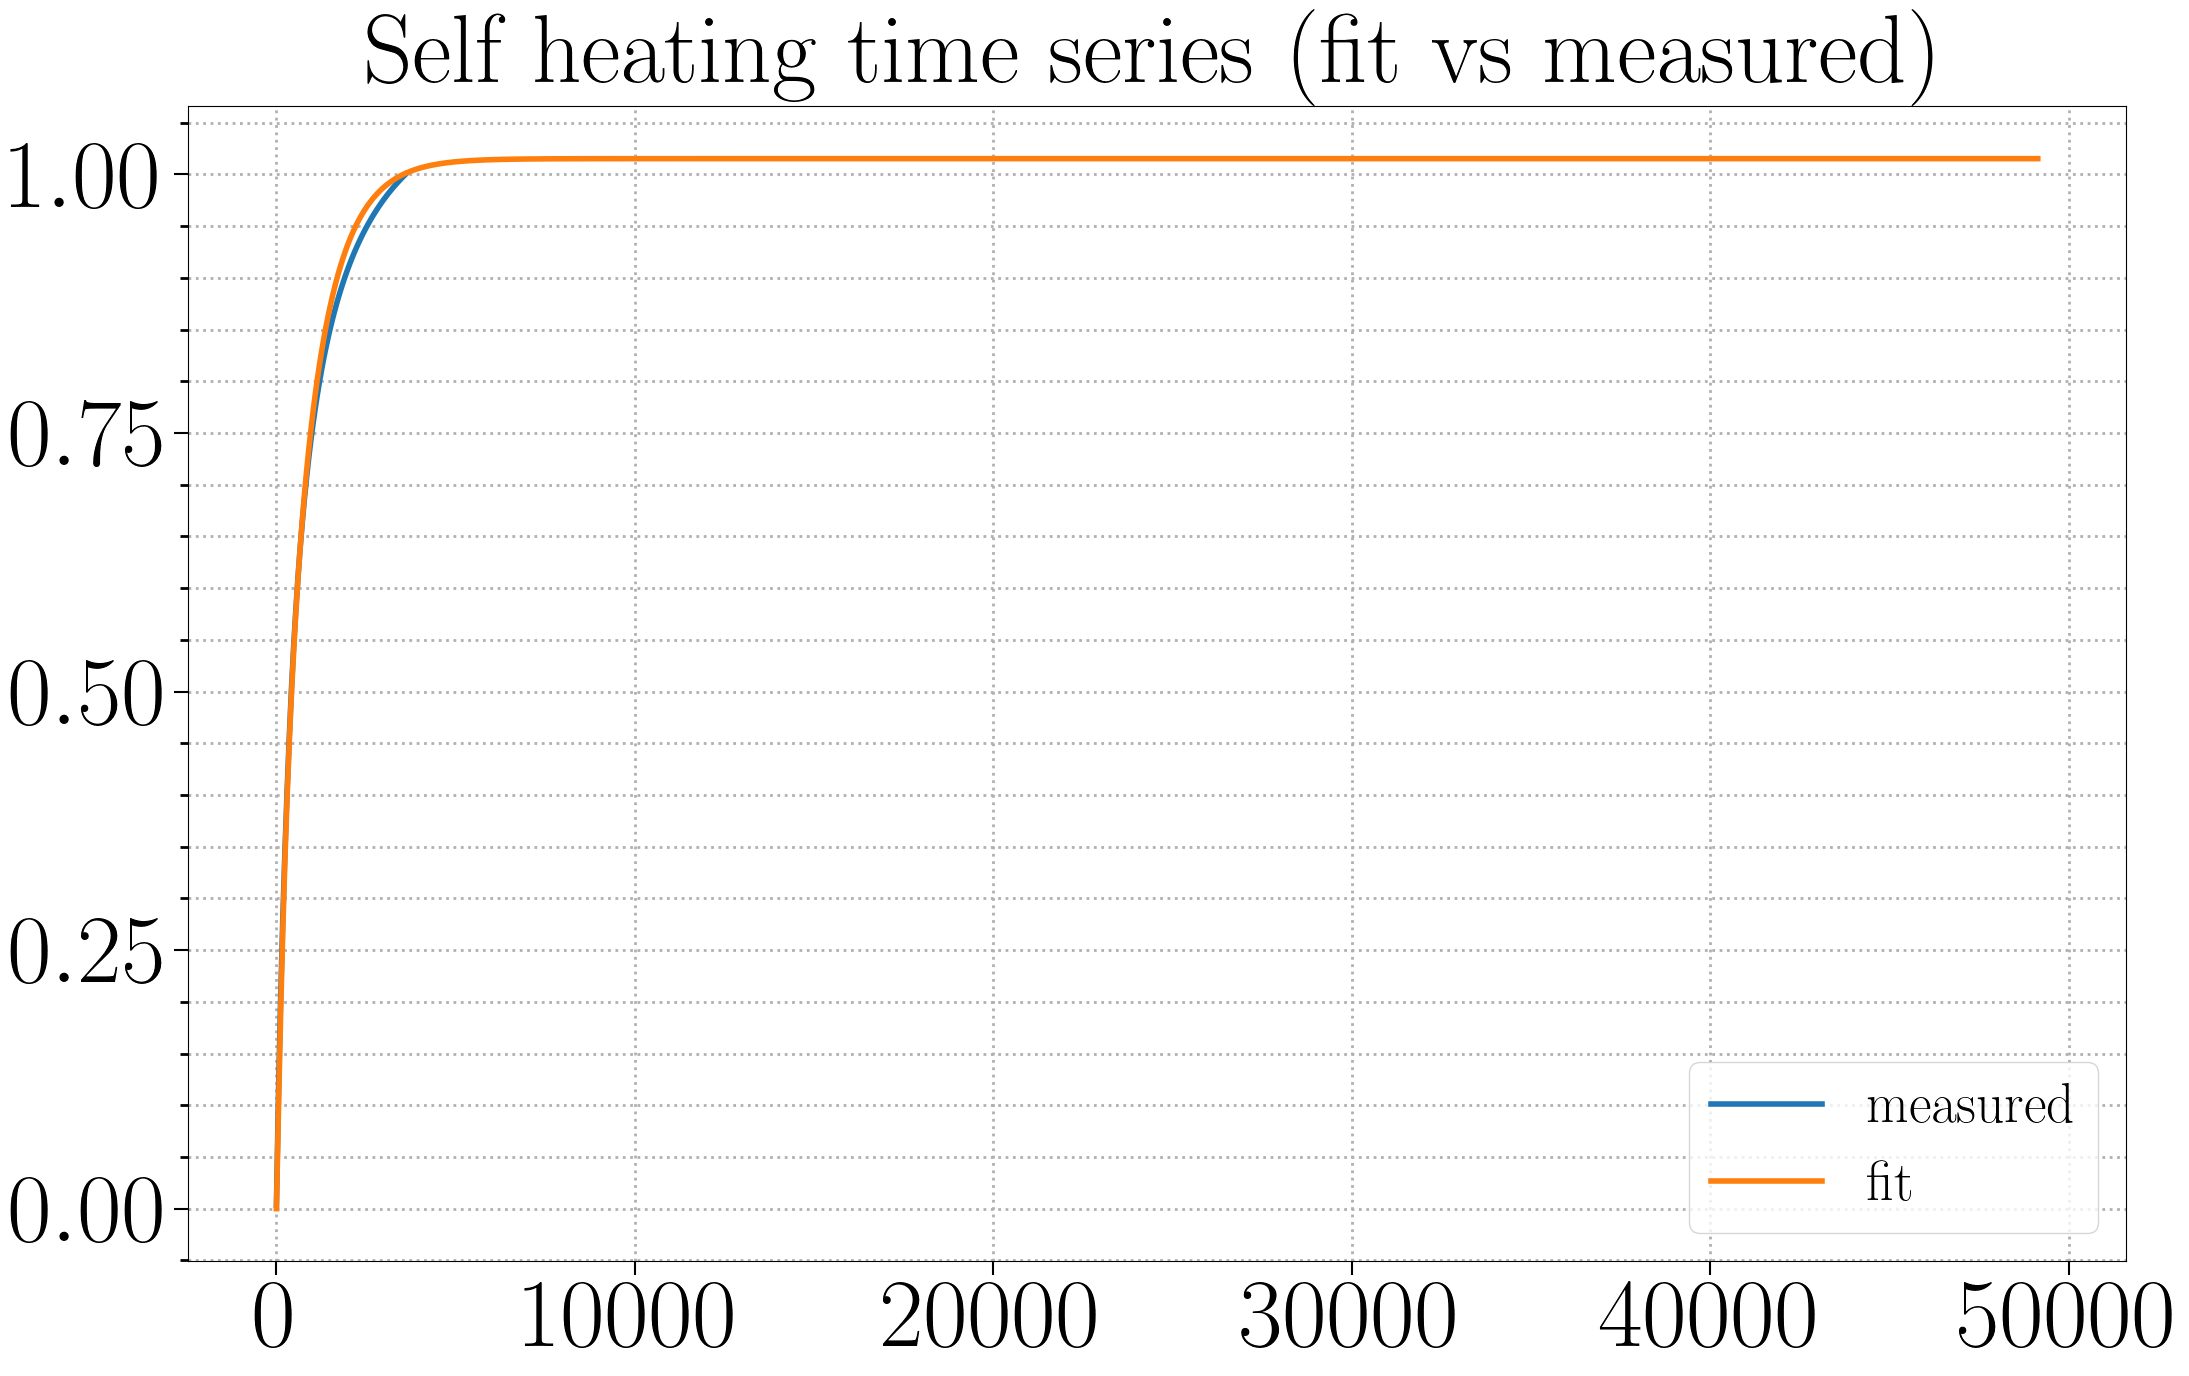

In [19]:
plt.plot(t_com,defocus,label='measured',linewidth=4)
plt.plot(trhy1,y_self_test_longer,label='fit',linewidth=4)
plt.title('Self heating time series (fit vs measured)')
plt.legend()

In [20]:
t_co2 = np.arange(0,len(co2y[:,0]),1)*60
defocus_co2 = (co2y_smooth + abs(min(co2y_smooth)))/P_CO2Y
ir_co2  = (defocus_co2[1:] - defocus_co2[:-1])
t_ir_co2 = t_co2[:((len(t_co2)-1))]

In [21]:
[F_ir_co2,H_ir_co2]=signal.freqz(ir_co2, 1, worN=3000,whole=False) 
Fs_co2 =1/(t_co2[1]-t_co2[0])

In [298]:
z1 = .165e-3
z2 = .38e-3
z3 = .43e-3
zeros_co2 = np.array([z1,z2, z3])
fit_zeros_co2 = -2.0*np.pi*zeros_co2
p1 = .135e-3
p2 = .135e-3
p3 = .175e-3
p4 = .24e-3
poles_co2 = np.array([p1, p2, p3, p4])
fit_poles_co2 = -2.0*np.pi*poles_co2

k_co2 = 1 #This gain is not initally correct

zpk_co2 = signal.ZerosPolesGain(fit_zeros_co2, fit_poles_co2, k_co2)
F_co2, H_co2 = signal.freqresp(zpk_co2, F_ir_co2*(Fs_co2/2.0))

Text(0.5, 1.0, 'CO2 filter')

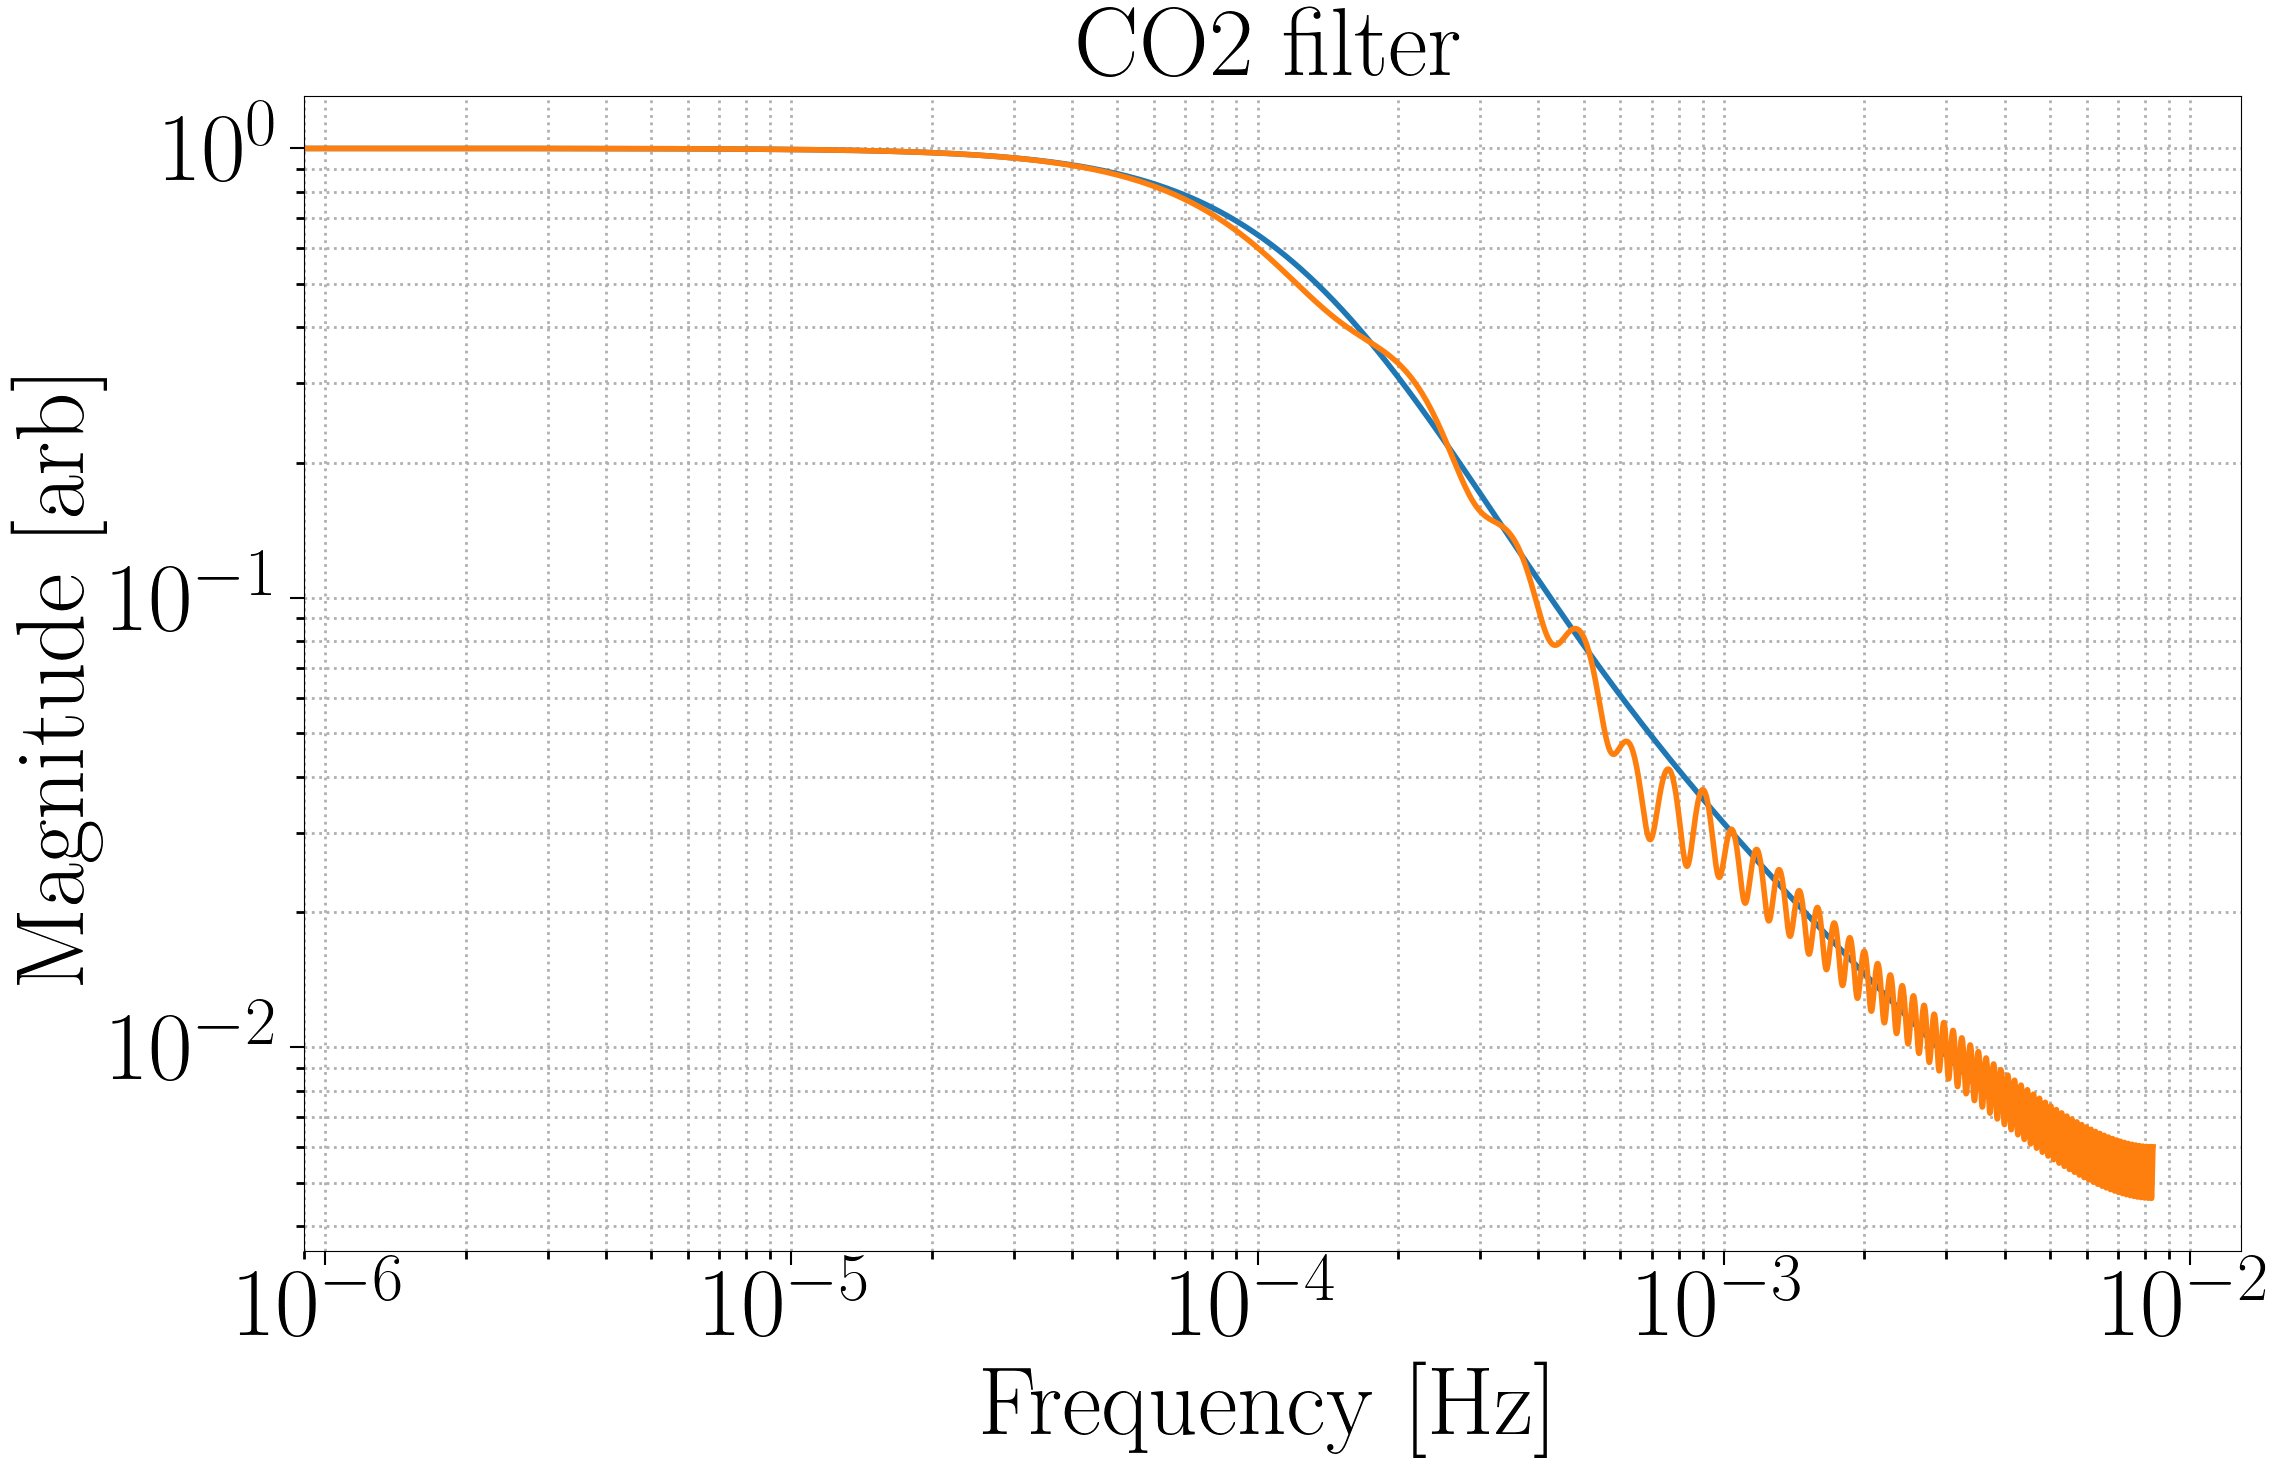

In [304]:
plt.loglog(F_co2/(2*np.pi), abs(H_co2)/abs(H_co2)[0], label='Fitted zpk Filter',linewidth=4)
plt.loglog(F_ir_co2*Fs_co2/(2*np.pi), abs(H_ir_co2)/abs(H_ir_co2)[0], label='Plant filter',linewidth=4)
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')
plt.title('CO2 filter')

In [305]:
k_new_co2 = 1/abs(H_co2)[0]

In [306]:
G_4 = signal.ZerosPolesGain(fit_zeros_co2, fit_poles_co2, k_new_co2)
[ _ ,y_co2_test_longer, _] = signal.lsim(G_4, unit_step_testing1, trhy1)

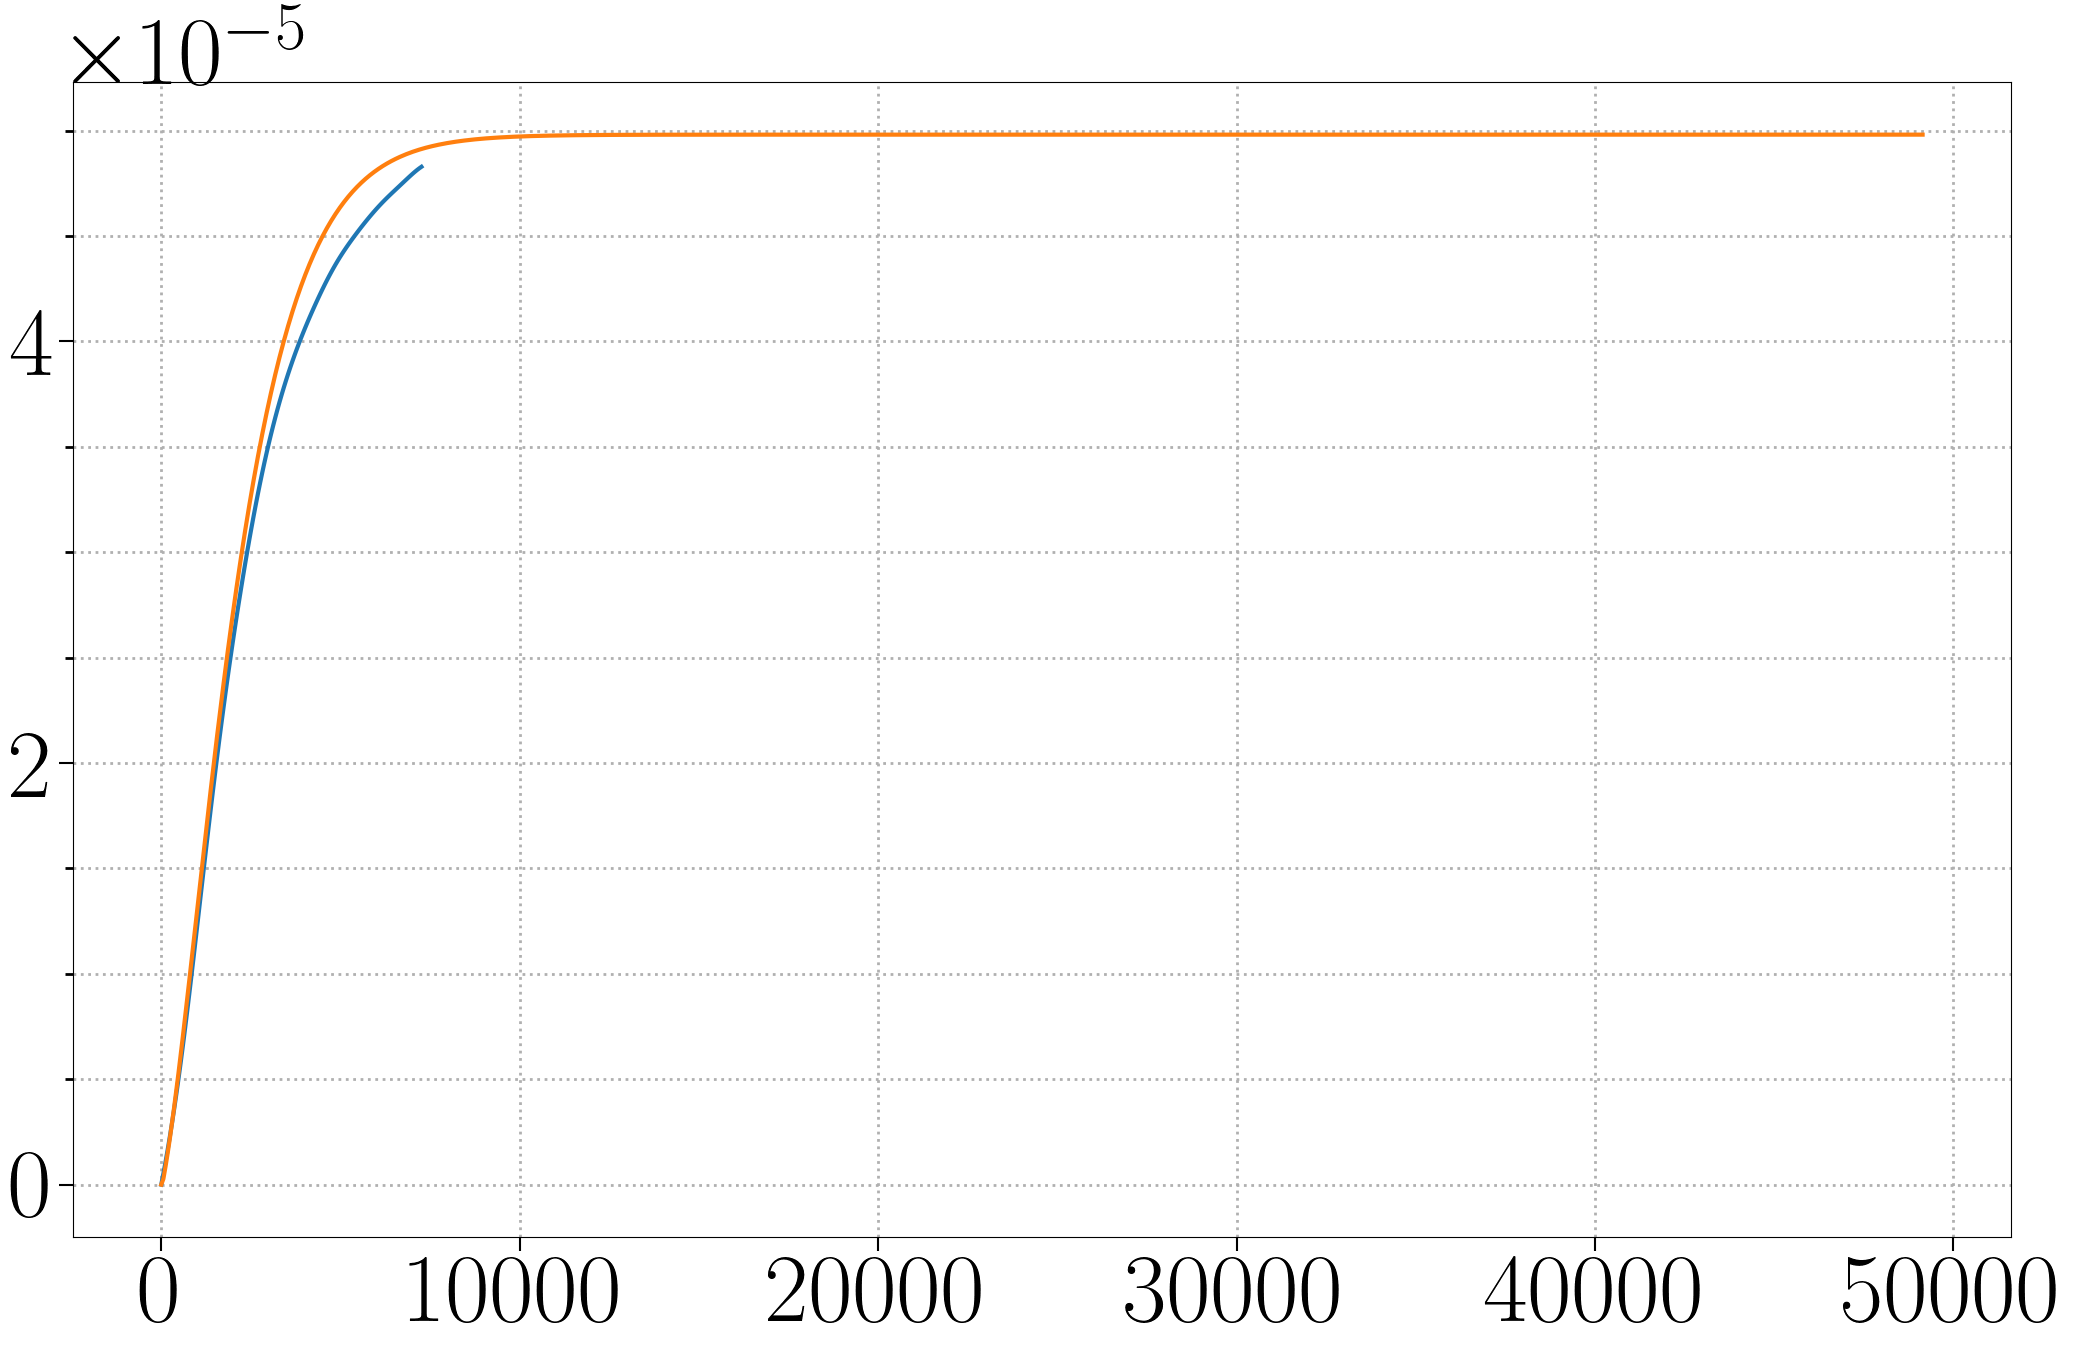

In [322]:
plt.plot(t,co2y_smooth + abs(min(co2y_smooth)), label='CO2Y laser (.95 W)')
plt.plot(trhy1, y_co2_test_longer*max(defocus_co2)*.98, label ='CO2Y laser (.95W) (filter)')

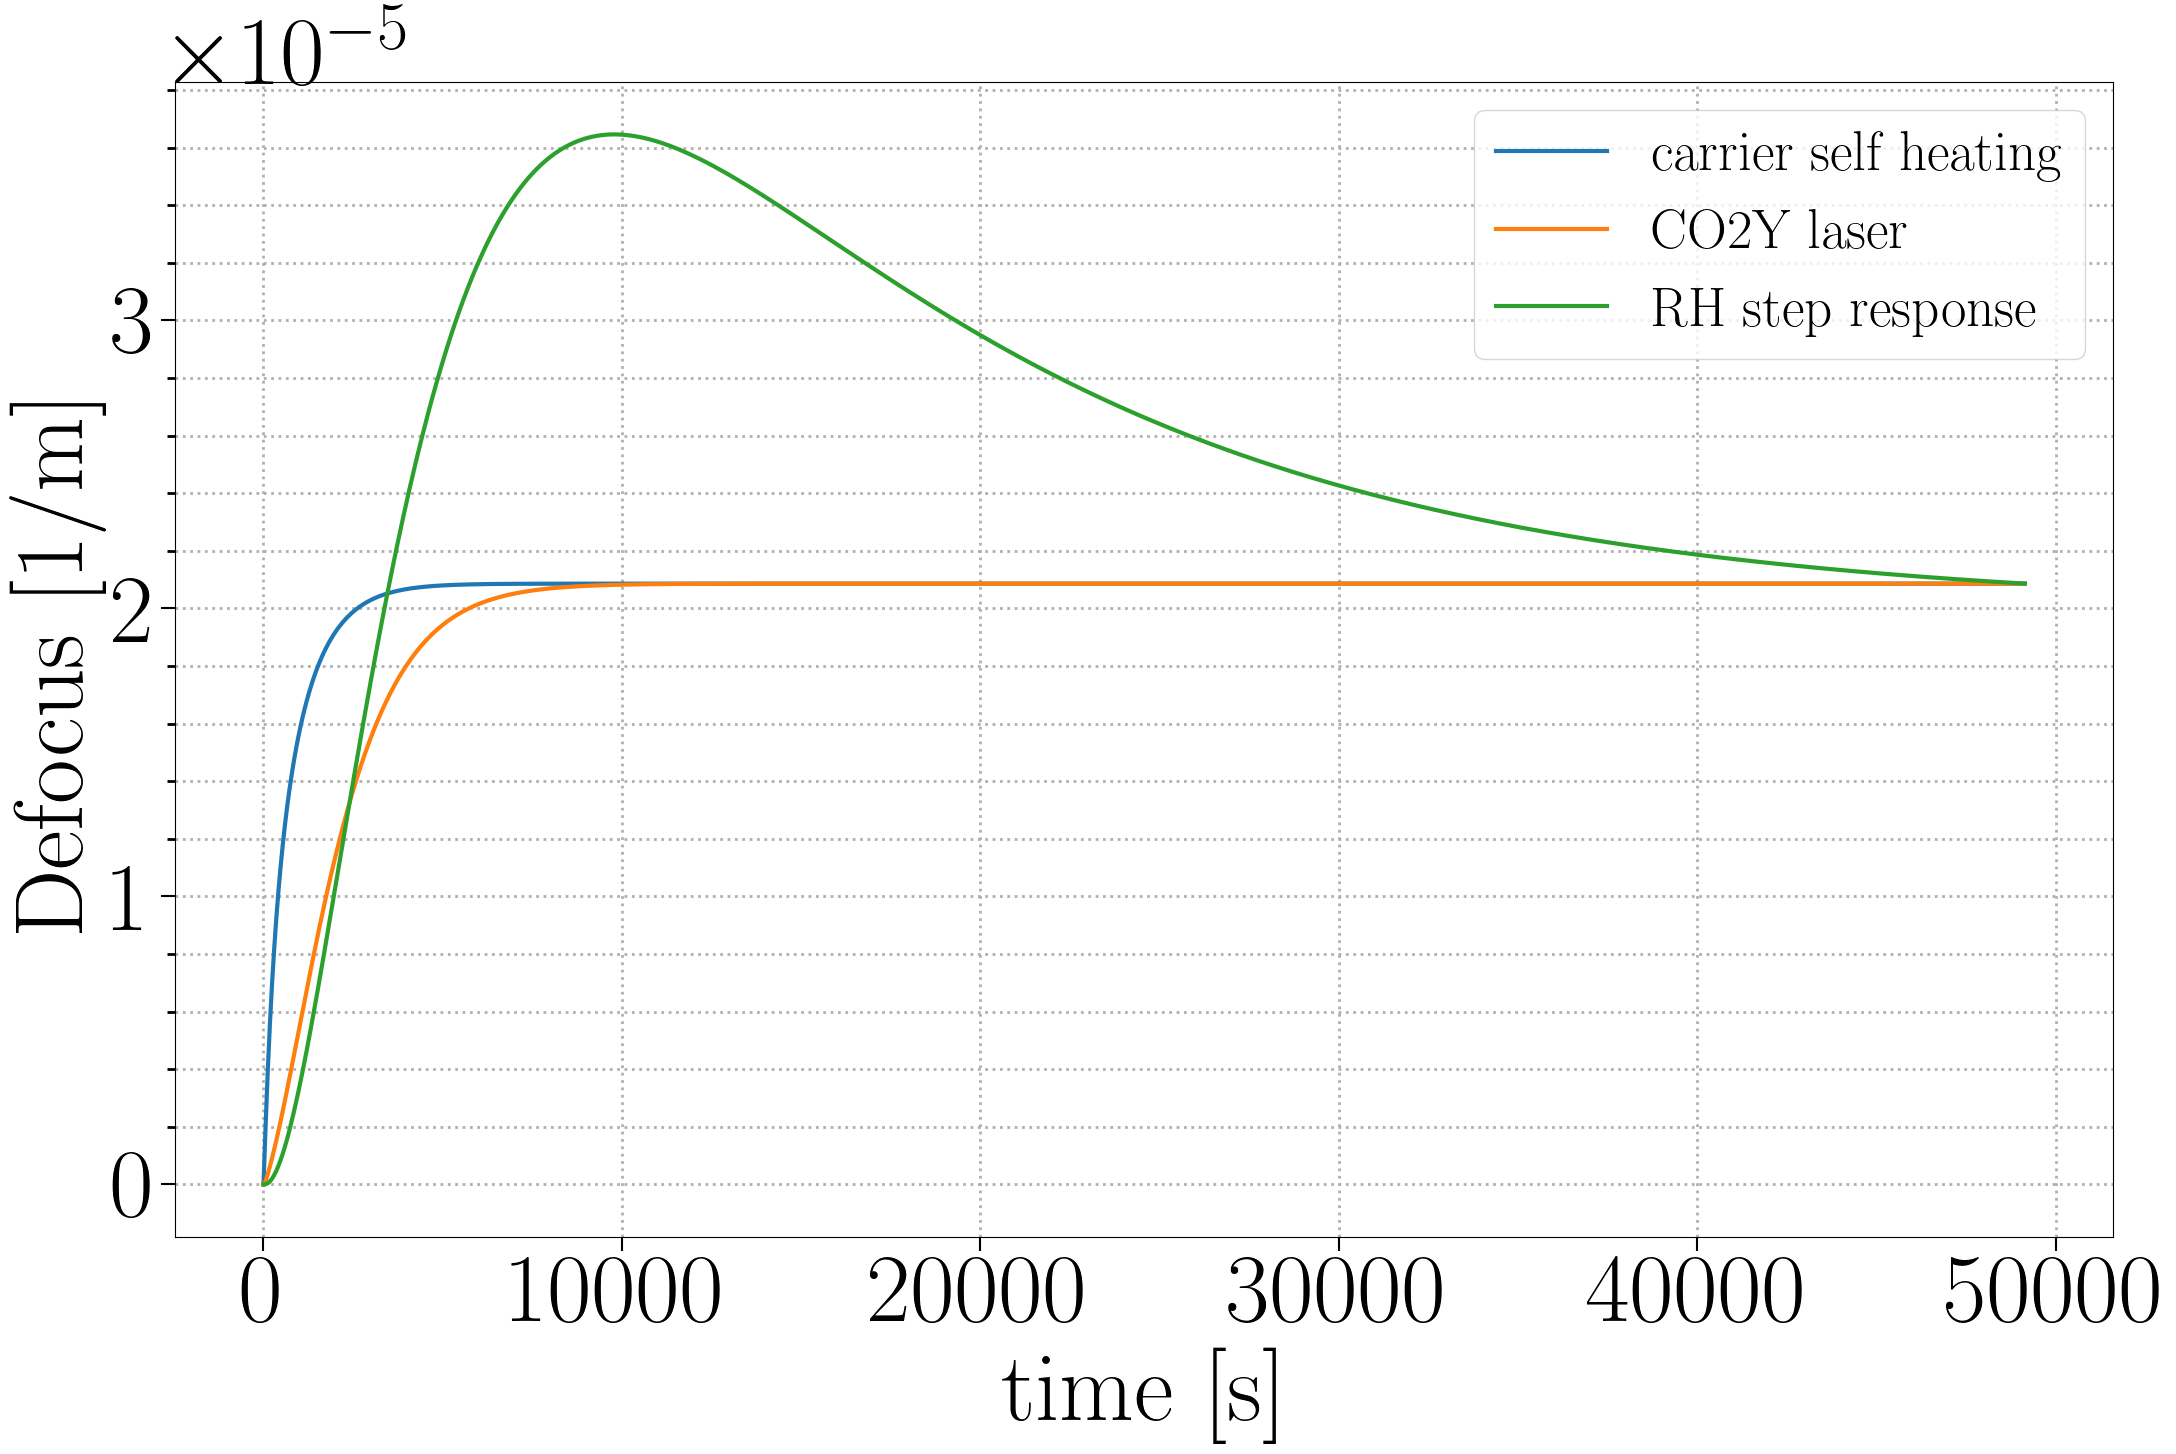

In [347]:
plt.plot(trhy1, y_self_test_longer*.985*(2.086*1e-5) , label='carrier self heating')
#plt.plot(t_rhy1,y_self_test_longer*.62e-4,label='fit',linewidth=4)

plt.plot(trhy1, y_co2_test_longer*(2.086*1e-5) , label='CO2Y laser')

plt.plot(trhy1, y_RH_test, label='RH step response')
#plt.plot(rhy[:,0], rhy[:,1])

plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Defocus [1/m]')
plt.savefig('../figs/TCS/TCS_resp_sim.pdf', dpi=300, bbox_inches='tight')

In [344]:
y_RH_test

array([0.00000000e+00, 5.75426129e-09, 3.96235937e-08, 1.05595399e-07,
       2.01816808e-07, 3.26514144e-07, 4.77989872e-07, 6.54619661e-07,
       8.54849556e-07, 1.07719325e-06, 1.32022946e-06, 1.58259941e-06,
       1.86300436e-06, 2.16020333e-06, 2.47301076e-06, 2.80029440e-06,
       3.14097319e-06, 3.49401524e-06, 3.85843591e-06, 4.23329593e-06,
       4.61769958e-06, 5.01079300e-06, 5.41176250e-06, 5.81983295e-06,
       6.23426624e-06, 6.65435981e-06, 7.07944519e-06, 7.50888665e-06,
       7.94207985e-06, 8.37845058e-06, 8.81745354e-06, 9.25857113e-06,
       9.70131235e-06, 1.01452117e-05, 1.05898280e-05, 1.10347436e-05,
       1.14795634e-05, 1.19239137e-05, 1.23674412e-05, 1.28098127e-05,
       1.32507138e-05, 1.36898481e-05, 1.41269367e-05, 1.45617171e-05,
       1.49939428e-05, 1.54233826e-05, 1.58498196e-05, 1.62730511e-05,
       1.66928875e-05, 1.71091519e-05, 1.75216796e-05, 1.79303177e-05,
       1.83349240e-05, 1.87353673e-05, 1.91315262e-05, 1.95232892e-05,
      

In [309]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

HWSY_real_decay_1 = np.max(HWSY) - HWSY

p_guess = [max(HWSY), .001, 0]

popt, pcov = curve_fit(func, t, HWSY_real_decay_1, p_guess )

NameError: name 'HWSY' is not defined

In [24]:
t2 = range(0,20000)
plt.figure()
plt.plot(t, HWSY_real_decay_1, 'ko', label="Original Data")
#plt.plot(t, HWSY_decay, 'b^', label="2nd order butter filter (twice)")
plt.plot(t2, func(t2, *popt), 'r-', label="Fitted Curve")
plt.grid(True)
plt.legend()
plt.show()
print(popt[0])
print(popt[1])
print(popt[2])

NameError: name 'HWSY_real_decay_1' is not defined

<Figure size 2500x1500 with 0 Axes>

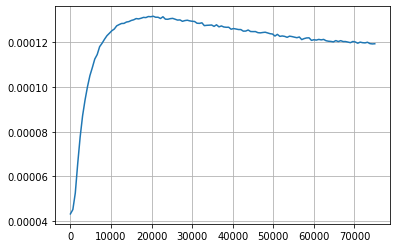

In [11]:
#IFO thermal response
#Load the Hartmann data
datay = np.loadtxt('../measurements/TCS_resp/ifo_thermal_response_12_07_2018/ITMY_HWS.dat')
datax = np.loadtxt('../measurements/TCS_resp/ifo_thermal_response_12_07_2018/ITMX_HWS.dat')

t_ifo = np.arange(0,len(datax[:-1,0]),1)*60*10
HWSY_ifo= datay[:-1,1]
HWSX_ifo =datax[:-1,1]
plt.plot(t_ifo,HWSY_ifo)
plt.grid(True)
plt.show()

In [16]:
y3

array([3.40349310e-06, 4.43337497e-06, 5.45629641e-06, 6.47067280e-06,
       7.47506379e-06, 8.46817653e-06, 9.44886690e-06, 1.04161388e-05,
       1.13691415e-05, 1.23071654e-05, 1.32296356e-05, 1.41361051e-05,
       1.50262453e-05, 1.58998367e-05, 1.67567582e-05, 1.75969752e-05,
       1.84205288e-05, 1.92275228e-05, 2.00181125e-05, 2.07924928e-05,
       2.15508868e-05, 2.22935355e-05, 2.30206876e-05, 2.37325909e-05,
       2.44294842e-05, 2.51115911e-05, 2.57791142e-05, 2.64322313e-05,
       2.70710924e-05, 2.76958184e-05, 2.83065009e-05, 2.89032029e-05,
       2.94859616e-05, 3.00547910e-05, 3.06096862e-05, 3.11506283e-05,
       3.16775896e-05, 3.21905400e-05, 3.26894525e-05, 3.31743099e-05,
       3.36451111e-05, 3.41018764e-05, 3.45446539e-05, 3.49735239e-05,
       3.53886036e-05, 3.57900502e-05, 3.61780644e-05, 3.65528913e-05,
       3.69148214e-05, 3.72641905e-05, 3.76013782e-05, 3.79268054e-05,
       3.82409311e-05, 3.85442483e-05, 3.88372786e-05, 3.91205667e-05,
      

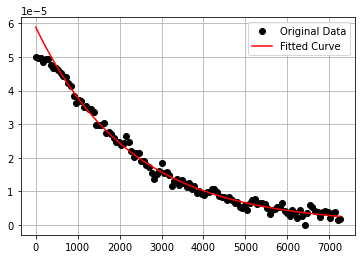

5.867393518730704e-05
0.0004429940902128605
1.945606530253643e-07


In [24]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

HWSY_real_decay = [(np.max(HWSY)-y3[i]) for i in range(len(y3))]

p_guess = [max(y3), .001, 0]

popt, pcov = curve_fit(func, t[8:-4], HWSY_real_decay, p_guess )

plt.figure()
plt.plot(t, HWSY_real_decay_1, 'ko', label="Original Data")
plt.plot(t, func(t, *popt), 'r-', label="Fitted Curve")
plt.grid(True)
plt.legend()
plt.show()
print(popt[0])
print(popt[1])
print(popt[2])